Структура (для каждого индекса отдельно)
1. Картинки с наложением по блокам!
2. Снижение размерности
2. Log reg, NN, CNN

Аналогии с разложением в ряд Фурье и вейвлет преобразованием ([сжатием](https://habr.com/ru/post/168517/)).

Если функция периодическая функция, то её лучше всего разложить в ряд по синусам и косинусам разных частот. Это применяется в теории колебаний и радиоэлектронике. Коэффициенты такого разложения показывают вклад разных частот в процесс (спектральные амплитуды) 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skmetrix
plt.style.use('ggplot')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from IPython.display import Image
from IPython.core.display import HTML 

from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests

%run /Users/vladimirkosarev/Desktop/Yandex.Disk.localized/2_disser_aspa/Python/ts_cnn/functions.ipynb

# import qgrid
# qgrid_widget=qgrid.show_grid(df,show_toolbar=True)
# df=qgrid_widget
# df.get_changed_df()

In [2]:
# os.chdir(r'C:\Users\vkosarev\YandexDisk\2_disser_aspa\data\Сбор_Росстат')

In [3]:
os.chdir('/Users/vladimirkosarev/Desktop/Yandex.Disk.localized/2_disser_aspa/data/Сбор_Росстат')

### Загрузка данных

In [4]:
xl=pd.ExcelFile('mydata.xlsx')
# Переменные реального сектора
ipp_ca=xl.parse('CA',skiprows=1,index_col='date',parse_dates=True)[['X13final', 'CA_binar',
       'inconf_r', 'inconf_e', 'ps_ca', 'ps_ew', 'ndpi','exp_duty_oil']]
ipp_ca.index=[get_last_day(i) for i in ipp_ca.index]
ipp_ca.index=pd.to_datetime(ipp_ca.index)
quart_ca=xl.parse('quarter',skiprows=1,index_col='date',parse_dates=True)[['inv_CA','s_ca','e_ca']]
# Переменные финансовго сектора
# Нефть и курс
nomex=xl.parse('nomex',skiprows=1,index_col='data',parse_dates=True)['curs']
ex=nomex.resample('M').mean()
ex.name='nomex'
brent=xl.parse('brent',skiprows=0,index_col='date',parse_dates=True)['close']
nf=brent.resample('M').mean()
nf.name='brent'
#инфляция
infl=xl.parse('infl',skiprows=1,index_col='date',parse_dates=True)[['ipp_nonprod','ipp_prod']]
infl.index=[get_last_day(i) for i in infl.index]
# кредиты нефинансовым организациям
credit=xl.parse('credit',skiprows=1,index_col='date',parse_dates=True)[['credit','payment', 'deposit_peop','m2_seas_adj']]/1000000
credit.index=[get_last_day(i) for i in credit.index]

In [5]:
real_block=pd.concat([ipp_ca,quart_ca],axis=1)[:'2019-09-30']
print(real_block.tail(5))
financ_block=pd.concat([ex,nf,infl,credit],axis=1)[:'2019-09-30']
# financ_block.corr()

              X13final  CA_binar  inconf_r  inconf_e  ps_ca  ps_ew  \
2019-05-31  110.890849       1.0       1.0      -8.0  81.78  66.83   
2019-06-30  110.717760       1.0       1.0      -6.0  73.06  59.76   
2019-07-31  110.453363       1.0       1.0      -5.0  74.85  61.48   
2019-08-31  110.506519       1.0       0.0       0.0  70.37  57.67   
2019-09-30  108.798578       1.0       0.0       2.0  73.61  60.04   

                    ndpi  exp_duty_oil  inv_CA   s_ca          e_ca  
2019-05-31  11295.170071   9431.254626     NaN    NaN           NaN  
2019-06-30  11647.416933   9573.834743  1328.9  622.5  3.996000e+09  
2019-07-31  11168.430450   9043.978143     NaN    NaN           NaN  
2019-08-31  10491.529789   8961.514050     NaN    NaN           NaN  
2019-09-30  10223.882908   8963.056618     NaN    NaN           NaN  


In [6]:
# import qgrid
# qgrid_widget=qgrid.show_grid(brent,show_toolbar=True)
# qgrid_widget

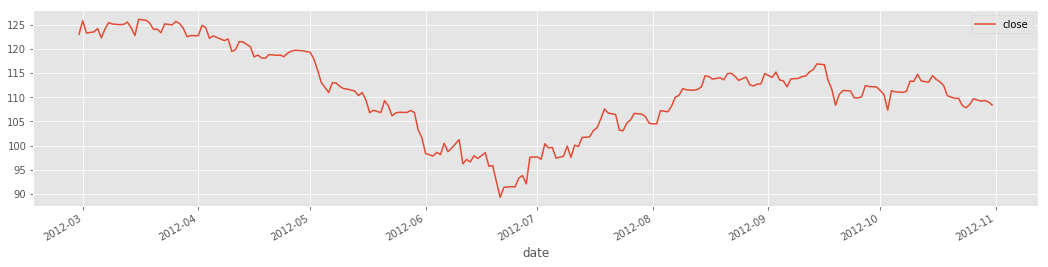

In [35]:
qgrid_widget.get_changed_df().plot(figsize=(18,4))

### Предобработка данных

In [7]:
# financ_block
# real_block=np.log(real_block)
real_block.head()

,X13final,CA_binar,inconf_r,inconf_e,ps_ca,ps_ew,ndpi,exp_duty_oil,inv_CA,s_ca,e_ca
2005-01-31,101.598560,1.0,3.0,-6.0,59.72,42.97,1660.100430,728.953571,NaN,NaN,NaN
2005-02-28,101.594109,1.0,3.0,-7.0,61.56,44.82,1845.351651,975.010704,NaN,NaN,NaN
2005-03-31,101.554718,1.0,6.0,-10.0,69.25,50.94,2008.630865,1203.145498,98.8,137.98,553776463.0
2005-04-30,101.051539,1.0,5.0,-9.0,69.37,50.64,1879.142335,1016.361203,NaN,NaN,NaN
2005-05-31,101.276387,1.0,8.0,-10.0,65.48,47.83,1872.515691,1014.429570,NaN,NaN,NaN


### CA

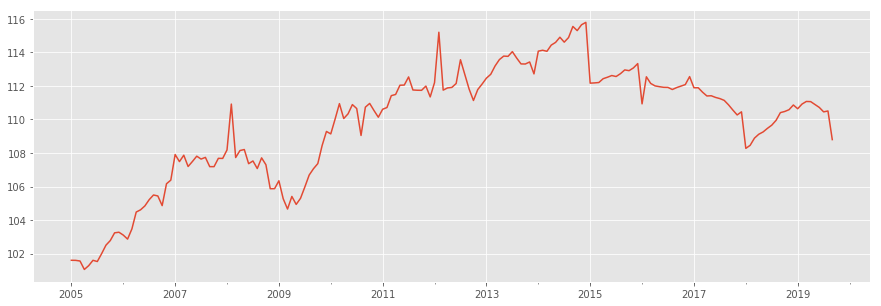

In [8]:
candidate_series=real_block.X13final
plt.rcParams['figure.figsize'] = (15, 5) #plot size
candidate_series.plot(grid=True) #series plot

In [9]:
candidate_series=real_block.X13final
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())
# candidate_series=candidate_series.diff().dropna()

adf:  -2.472069531516275
p-value:  0.12241883687623334
Critical values:  {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}
есть единичные корни, ряд не стационарен
adf:  -11.512135319126411
p-value:  4.234618187143353e-21
Critical values:  {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}
единичных корней нет, ряд стационарен


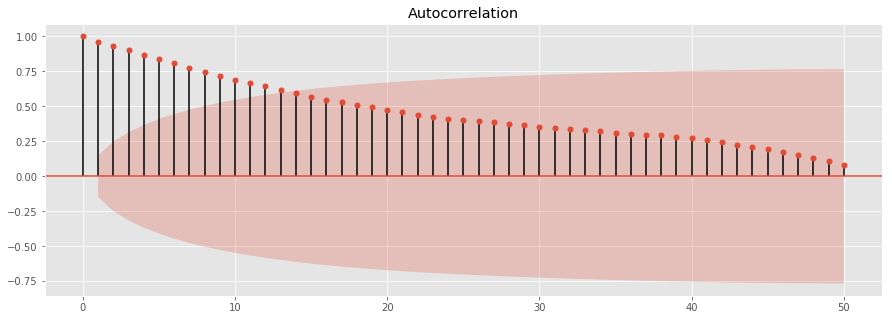

In [27]:
plot_acf(candidate_series, lags = 50) #ACF for reasonable number of lags.
# plt.show()#Blue space denotes 95% confidence interval for H0: no autocorrelation is present.
plt.savefig('acf1.png')

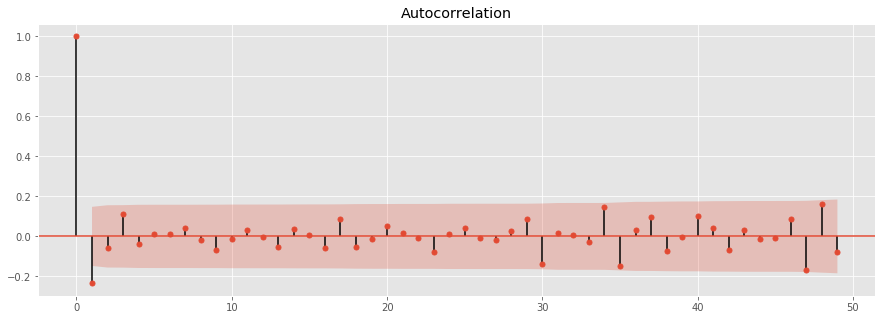

In [30]:
plot_acf(candidate_series.diff().dropna(), lags = 49) #ACF for reasonable number of lags.
# plt.show() #
plt.savefig('pacf1.png')

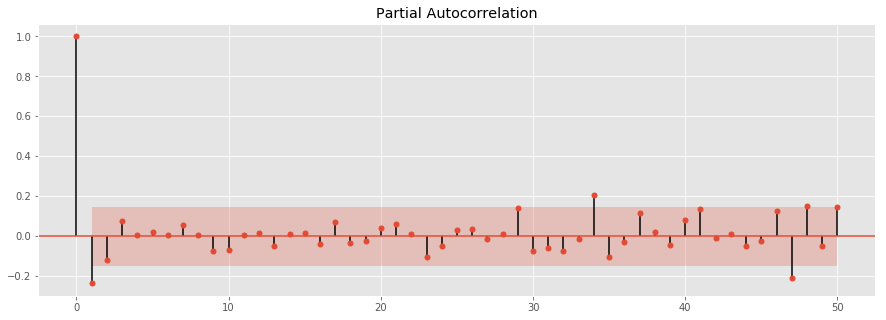

In [31]:
plot_pacf(candidate_series.diff().dropna(), lags = 50) #PACF plot for reasonable number of lags.
# plt.show()
plt.savefig('pacf1.png')

In [10]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR
model = AR(candidate_series)
rez={}
for i in [1,2,3,4,5,6,7,8,9,11,12]:
    result = model.fit(i)
    rez['Lag Order ='+str(i)]=[result.aic,result.bic,result.fpe,result.hqic]
df_ic=pd.DataFrame(rez,index=['AIC','BIC','FPE','HQIC']).T
df_ic.sort_values('BIC')

,AIC,BIC,FPE,HQIC
Lag Order =2,-0.513498,-0.441160,0.591601,-0.484156
Lag Order =3,-0.513907,-0.423130,0.591323,-0.477082
Lag Order =1,-0.472578,-0.418536,0.616349,-0.450659
Lag Order =4,-0.510101,-0.400738,0.593543,-0.465733
Lag Order =5,-0.493765,-0.365670,0.603285,-0.441794
Lag Order =6,-0.476237,-0.329258,0.613922,-0.416599
Lag Order =7,-0.459717,-0.293704,0.624120,-0.392351
Lag Order =8,-0.444593,-0.259392,0.633607,-0.369435
Lag Order =9,-0.426400,-0.221855,0.645220,-0.343386
Lag Order =11,-0.399236,-0.155526,0.662966,-0.300312


Выводы
стационарен в первых разностях
шварц в отличие от акаике является состоятельным (носко), как и хенана куина
автокр функ показывает 12 лагов, частная автокр функция 2 лага, но на нестац ряде! 

### Объясняющие переменные

In [11]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
def preproc(X,freq_n=12):
    cycle, trend = hpfilter(X, 160000000)
    ses = seasonal_decompose(X, model='additive', freq=freq_n).seasonal
    X=X-trend-ses
    X=(X-X.mean())/X.std()#стандартизация 
    # X=(X-X.min())/(X.max()-X.min())#нормирование
    return X

In [12]:
for i in  real_block.columns:
    print('__________________________')
    print(i)
    candidate_series=real_block[i]
    dd=pd.concat([real_block.X13final.diff().dropna(),preproc(candidate_series).diff().dropna()],axis=1)
    grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True).values

__________________________
X13final

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6732  , p=0.1039  , df_denom=172, df_num=1
ssr based chi2 test:   chi2=2.7198  , p=0.0991  , df=1
likelihood ratio test: chi2=2.6989  , p=0.1004  , df=1
parameter F test:         F=2.6732  , p=0.1039  , df_denom=172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4468  , p=0.0896  , df_denom=169, df_num=2
ssr based chi2 test:   chi2=5.0384  , p=0.0805  , df=2
likelihood ratio test: chi2=4.9668  , p=0.0835  , df=2
parameter F test:         F=2.4468  , p=0.0896  , df_denom=169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7539  , p=0.1580  , df_denom=166, df_num=3
ssr based chi2 test:   chi2=5.4836  , p=0.1396  , df=3
likelihood ratio test: chi2=5.3985  , p=0.1448  , df=3
parameter F test:         F=1.7539  , p=0.1580  , df_denom=166, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F 

ssr based F test:         F=1.1490  , p=0.3262  , df_denom=139, df_num=12
ssr based chi2 test:   chi2=16.2681 , p=0.1793  , df=12
likelihood ratio test: chi2=15.5109 , p=0.2147  , df=12
parameter F test:         F=1.1490  , p=0.3262  , df_denom=139, df_num=12
__________________________
ps_ca

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2263  , p=0.2697  , df_denom=172, df_num=1
ssr based chi2 test:   chi2=1.2477  , p=0.2640  , df=1
likelihood ratio test: chi2=1.2433  , p=0.2648  , df=1
parameter F test:         F=1.2263  , p=0.2697  , df_denom=172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0485  , p=0.3527  , df_denom=169, df_num=2
ssr based chi2 test:   chi2=2.1591  , p=0.3397  , df=2
likelihood ratio test: chi2=2.1458  , p=0.3420  , df=2
parameter F test:         F=1.0485  , p=0.3527  , df_denom=169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2610  , p=0.0063  , df_deno

parameter F test:         F=0.6458  , p=0.6934  , df_denom=157, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9411  , p=0.4767  , df_denom=154, df_num=7
ssr based chi2 test:   chi2=7.2291  , p=0.4054  , df=7
likelihood ratio test: chi2=7.0787  , p=0.4207  , df=7
parameter F test:         F=0.9411  , p=0.4767  , df_denom=154, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7985  , p=0.6047  , df_denom=151, df_num=8
ssr based chi2 test:   chi2=7.1076  , p=0.5251  , df=8
likelihood ratio test: chi2=6.9614  , p=0.5408  , df=8
parameter F test:         F=0.7985  , p=0.6047  , df_denom=151, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6940  , p=0.7135  , df_denom=148, df_num=9
ssr based chi2 test:   chi2=7.0483  , p=0.6321  , df=9
likelihood ratio test: chi2=6.9036  , p=0.6472  , df=9
parameter F test:         F=0.6940  , p=0.7135  , df_denom=148, df_num=9

Granger Causality
nu

ValueError: This function does not handle missing values

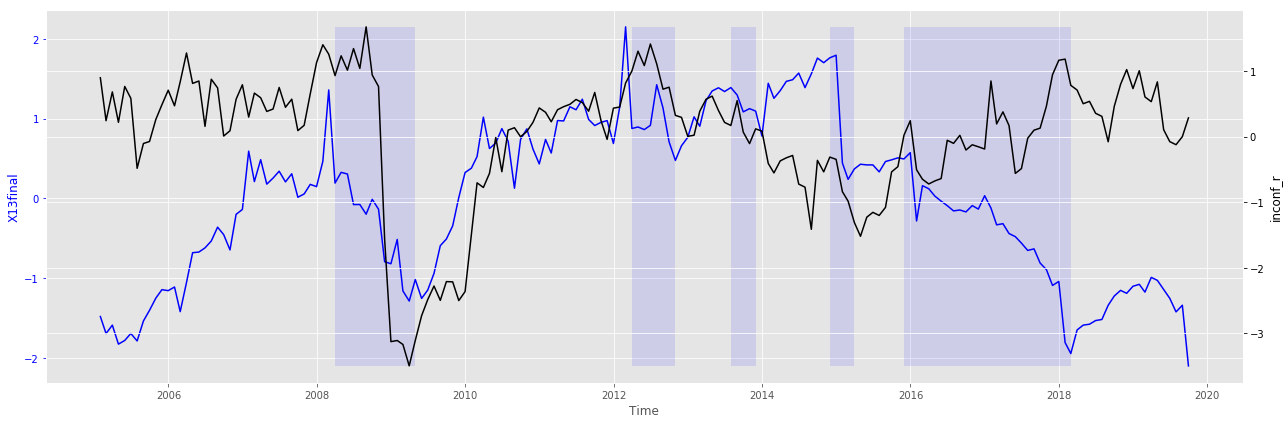

In [599]:
# inconf_r
fplot(real_block.index, preproc(real_block.X13final),preproc(real_block.inconf_r),real_block.CA_binar,1)

In [600]:
candidate_series=real_block.inconf_r
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())

adf:  -3.0809294551519826
p-value:  0.027997063784879327
Critical values:  {'1%': -3.47086589632514, '5%': -2.879330279087651, '10%': -2.57625492712671}
единичных корней нет, ряд стационарен
adf:  -3.3966494551914654
p-value:  0.011073623123469468
Critical values:  {'1%': -3.47086589632514, '5%': -2.879330279087651, '10%': -2.57625492712671}
единичных корней нет, ряд стационарен


In [601]:
#stationary series are needed for the test
#H0: series 2 do not Granger-cause series 1
dd=pd.concat([real_block.X13final.diff().dropna(),preproc(hpfilter(real_block.inconf_r, 0.2)[1])[1:]],axis=1)
grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True)
# стационарен в разностях (значит его нужно в гр всегда в ращностях смотреть), стационарен в уровнях
# Причинность есть при лаг=2 при inconf_r сглаженным с хп 0.2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7502  , p=0.3876  , df_denom=172, df_num=1
ssr based chi2 test:   chi2=0.7633  , p=0.3823  , df=1
likelihood ratio test: chi2=0.7616  , p=0.3828  , df=1
parameter F test:         F=0.7502  , p=0.3876  , df_denom=172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4108  , p=0.0928  , df_denom=169, df_num=2
ssr based chi2 test:   chi2=4.9643  , p=0.0836  , df=2
likelihood ratio test: chi2=4.8948  , p=0.0865  , df=2
parameter F test:         F=2.4108  , p=0.0928  , df_denom=169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4620  , p=0.2268  , df_denom=166, df_num=3
ssr based chi2 test:   chi2=4.5709  , p=0.2060  , df=3
likelihood ratio test: chi2=4.5116  , p=0.2113  , df=3
parameter F test:         F=1.4620  , p=0.2268  , df_denom=166, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1564  , p=0.3321  

{1: ({'ssr_ftest': (0.7501905378719553, 0.3876224836840755, 172.0, 1),
   'ssr_chi2test': (0.7632752565557686, 0.3823054791213346, 1),
   'lrtest': (0.7616155404523965, 0.38282341583222135, 1),
   'params_ftest': (0.7501905378718814, 0.3876224836840998, 172.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.410832972007223, 0.09282101554288856, 169.0, 2),
   'ssr_chi2test': (4.964318782594755, 0.08356258630528289, 2),
   'lrtest': (4.894820160203608, 0.08651736964124905, 2),
   'params_ftest': (2.410832972007243, 0.09282101554288723, 169.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.4619965784389761, 0.22682146172163475, 166.0, 3),
   'ssr_chi2test': (4.570941109697762, 0.20604911865085984, 3),
   'lrtest': (4.5115982835818045, 0.2112580771287651, 3),
   'params_ftest': (1.461996578438912, 0.22682146172165066, 166.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

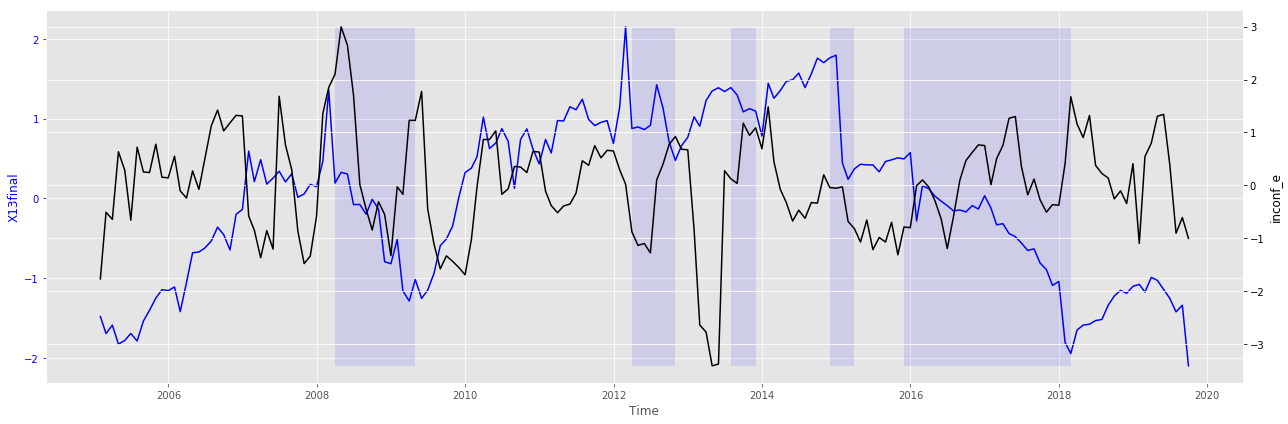

In [602]:
# inconf_e
fplot(real_block.index, preproc(real_block.X13final),preproc(real_block.inconf_e),real_block.CA_binar,1)

In [603]:
candidate_series=real_block.inconf_e
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())

adf:  -3.0779552849723477
p-value:  0.028228196191640867
Critical values:  {'1%': -3.47086589632514, '5%': -2.879330279087651, '10%': -2.57625492712671}
единичных корней нет, ряд стационарен
adf:  -6.224446585518595
p-value:  5.129134513080202e-08
Critical values:  {'1%': -3.47086589632514, '5%': -2.879330279087651, '10%': -2.57625492712671}
единичных корней нет, ряд стационарен


In [604]:
dd=pd.concat([real_block.X13final.diff().dropna(),preproc(hpfilter(real_block.inconf_e, 0.2)[1])[1:]],axis=1)
grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True)
#стационарен в уровнях,
# причинность 10, 11 лаг только с preproc


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7524  , p=0.3869  , df_denom=172, df_num=1
ssr based chi2 test:   chi2=0.7655  , p=0.3816  , df=1
likelihood ratio test: chi2=0.7638  , p=0.3821  , df=1
parameter F test:         F=0.7524  , p=0.3869  , df_denom=172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5483  , p=0.5789  , df_denom=169, df_num=2
ssr based chi2 test:   chi2=1.1291  , p=0.5686  , df=2
likelihood ratio test: chi2=1.1255  , p=0.5696  , df=2
parameter F test:         F=0.5483  , p=0.5789  , df_denom=169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4406  , p=0.7243  , df_denom=166, df_num=3
ssr based chi2 test:   chi2=1.3776  , p=0.7108  , df=3
likelihood ratio test: chi2=1.3721  , p=0.7121  , df=3
parameter F test:         F=0.4406  , p=0.7243  , df_denom=166, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4469  , p=0.7746  

{1: ({'ssr_ftest': (0.7523881370054205, 0.38692970851055697, 172.0, 1),
   'ssr_chi2test': (0.7655111859066779, 0.3816092951048776, 1),
   'lrtest': (0.7638417458246067, 0.3821289257619206, 1),
   'params_ftest': (0.7523881370053451, 0.38692970851058106, 172.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5483446953103525, 0.5789303094729626, 169.0, 2),
   'ssr_chi2test': (1.1291358222958736, 0.5686057819051942, 2),
   'lrtest': (1.1254879523418708, 0.5696438282556837, 2),
   'params_ftest': (0.5483446953103425, 0.5789303094729626, 169.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.4406180032982898, 0.7242539420975975, 166.0, 3),
   'ssr_chi2test': (1.3775948416374242, 0.7107949260244493, 3),
   'lrtest': (1.3721389088346427, 0.7120783221438225, 3),
   'params_ftest': (0.44061800329831596, 0.7242539420975844, 166.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

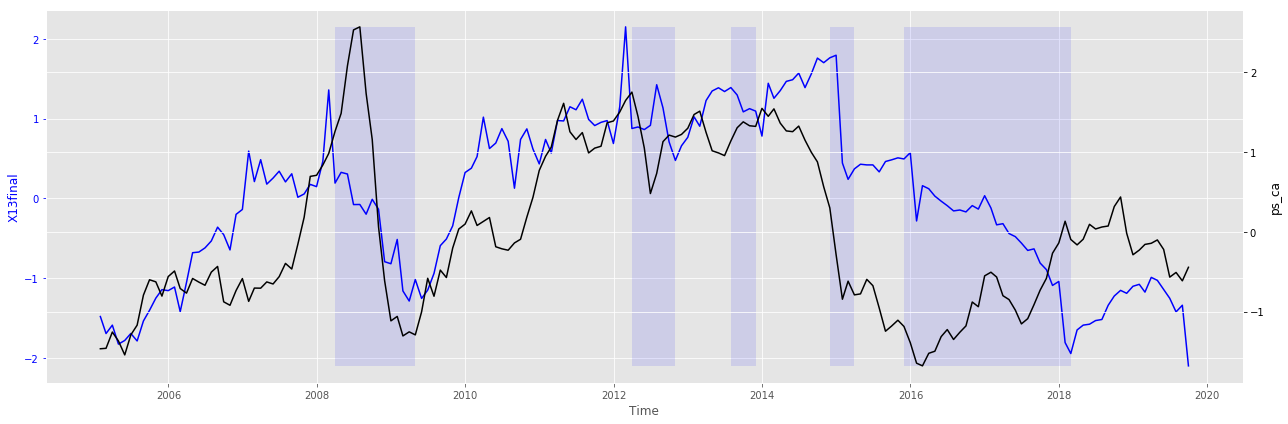

In [605]:
### ps_ca
fplot(real_block.index, preproc(real_block.X13final),preproc(real_block.ps_ca),real_block.CA_binar,1)

In [606]:
candidate_series=real_block.ps_ca
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())

#stationary series are needed for the test
#H0: series 2 do not Granger-cause series 1
dd=pd.concat([real_block.X13final.diff().dropna(),hpfilter(real_block.ps_ca, 0.2)[1][1:]],axis=1)
grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True)

# стационарен в уровнях на 10% уровне значимости
# ряд является причинным по грейджеру, значимыми оказываются лаги в 4, 5, 6 месяцев
# Индекс стоимости на бирже влияет на производство с 4 месячным лагом. 

adf:  -2.74185265987914
p-value:  0.06707168539855803
Critical values:  {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}
есть единичные корни, ряд не стационарен
adf:  -8.248660368146858
p-value:  5.466038818653779e-13
Critical values:  {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}
единичных корней нет, ряд стационарен

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6997  , p=0.4040  , df_denom=172, df_num=1
ssr based chi2 test:   chi2=0.7119  , p=0.3988  , df=1
likelihood ratio test: chi2=0.7105  , p=0.3993  , df=1
parameter F test:         F=0.6997  , p=0.4040  , df_denom=172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7460  , p=0.1776  , df_denom=169, df_num=2
ssr based chi2 test:   chi2=3.5954  , p=0.1657  , df=2
likelihood ratio test: chi2=3.5588  , p=0.1687  , df=2
parameter F test:         F=1.7460  , p=0.1776  , df_denom=169, df_num=2

Gra

{1: ({'ssr_ftest': (0.6997411869214636, 0.4040313303731783, 172.0, 1),
   'ssr_chi2test': (0.7119459750654427, 0.39879855131986375, 1),
   'lrtest': (0.7105016992366586, 0.3992773102137168, 1),
   'params_ftest': (0.6997411869214231, 0.4040313303731976, 172.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.7460489037914362, 0.17759420949867477, 169.0, 2),
   'ssr_chi2test': (3.595414310765798, 0.16567832771933275, 2),
   'lrtest': (3.5587716596991186, 0.1687417515969598, 2),
   'params_ftest': (1.7460489037914702, 0.1775942094986673, 169.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.2413169882443984, 0.2964782210810213, 166.0, 3),
   'ssr_chi2test': (3.8809850415592937, 0.2746056988422584, 3),
   'lrtest': (3.838093406120265, 0.2794862127938248, 3),
   'params_ftest': (1.2413169882443684, 0.2964782210810306, 166.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

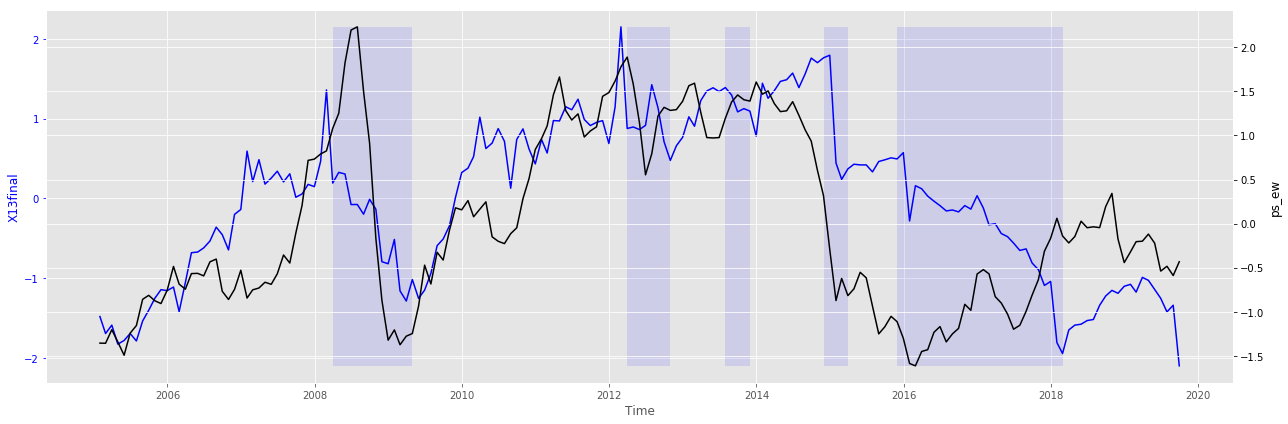

In [607]:
# 'ps_ew','ndpi', 'exp_duty_oil', 'inv_CA', 's_ca', 'e_ca'
fplot(real_block.index, preproc(real_block.X13final),preproc(real_block.ps_ew),real_block.CA_binar,1)


In [608]:
candidate_series=real_block.ps_ew
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())

adf:  -2.8376778436814094
p-value:  0.05309004224160752
Critical values:  {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}
есть единичные корни, ряд не стационарен
adf:  -8.262033421609791
p-value:  5.053023060517782e-13
Critical values:  {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}
единичных корней нет, ряд стационарен


In [609]:
dd=pd.concat([real_block.X13final.diff().dropna(),preproc(real_block.ps_ew).diff().dropna()],axis=1)
grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True)
# с 3 го лага причинен


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9627  , p=0.3279  , df_denom=172, df_num=1
ssr based chi2 test:   chi2=0.9795  , p=0.3223  , df=1
likelihood ratio test: chi2=0.9768  , p=0.3230  , df=1
parameter F test:         F=0.9627  , p=0.3279  , df_denom=172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9056  , p=0.4063  , df_denom=169, df_num=2
ssr based chi2 test:   chi2=1.8648  , p=0.3936  , df=2
likelihood ratio test: chi2=1.8548  , p=0.3956  , df=2
parameter F test:         F=0.9056  , p=0.4063  , df_denom=169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1547  , p=0.0072  , df_denom=166, df_num=3
ssr based chi2 test:   chi2=12.9897 , p=0.0047  , df=3
likelihood ratio test: chi2=12.5251 , p=0.0058  , df=3
parameter F test:         F=4.1547  , p=0.0072  , df_denom=166, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1373  , p=0.0162  

{1: ({'ssr_ftest': (0.9626899987639977, 0.3278881516055565, 172.0, 1),
   'ssr_chi2test': (0.9794811033936024, 0.3223269469546348, 1),
   'lrtest': (0.9767501937043335, 0.3230024501297555, 1),
   'params_ftest': (0.9626899987638978, 0.3278881516055855, 172.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9055920232828937, 0.40625518869003063, 169.0, 2),
   'ssr_chi2test': (1.8647693733872603, 0.39361394435765945, 2),
   'lrtest': (1.854847769789103, 0.39557143647175624, 2),
   'params_ftest': (0.9055920232828771, 0.4062551886900383, 169.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.154699188936567, 0.007199667473765306, 166.0, 3),
   'ssr_chi2test': (12.989692042518543, 0.004658950095274714, 3),
   'lrtest': (12.525140929752354, 0.0057846018169343105, 3),
   'params_ftest': (4.154699188936587, 0.007199667473765119, 166.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.,

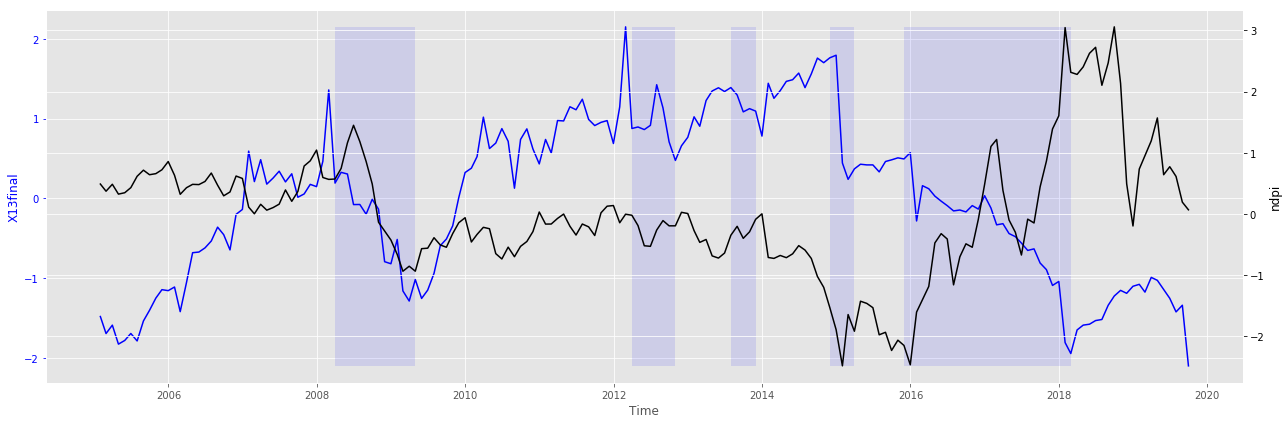

In [610]:
# 'ndpi', 'exp_duty_oil', 'inv_CA', 's_ca', 'e_ca'
fplot(real_block.index, preproc(real_block.X13final),preproc(real_block.ndpi),real_block.CA_binar,1)

In [611]:
candidate_series=real_block.ndpi
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())

adf:  -1.5334285053896823
p-value:  0.5169147248314744
Critical values:  {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}
есть единичные корни, ряд не стационарен
adf:  -11.665775632262248
p-value:  1.885808144965889e-21
Critical values:  {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}
единичных корней нет, ряд стационарен


In [612]:
dd=pd.concat([real_block.X13final.diff().dropna(),preproc(hpfilter(real_block.ndpi, 0.2)[1]).diff().dropna()],axis=1)
grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True)
# нет причинности, скорее всего ставка налог в объемах или он повышается после того, как в казне становится не хватать денег


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9841  , df_denom=172, df_num=1
ssr based chi2 test:   chi2=0.0004  , p=0.9839  , df=1
likelihood ratio test: chi2=0.0004  , p=0.9839  , df=1
parameter F test:         F=0.0004  , p=0.9841  , df_denom=172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3072  , p=0.7359  , df_denom=169, df_num=2
ssr based chi2 test:   chi2=0.6325  , p=0.7289  , df=2
likelihood ratio test: chi2=0.6313  , p=0.7293  , df=2
parameter F test:         F=0.3072  , p=0.7359  , df_denom=169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3341  , p=0.8007  , df_denom=166, df_num=3
ssr based chi2 test:   chi2=1.0446  , p=0.7905  , df=3
likelihood ratio test: chi2=1.0415  , p=0.7912  , df=3
parameter F test:         F=0.3341  , p=0.8007  , df_denom=166, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3907  , p=0.8151  

{1: ({'ssr_ftest': (0.0003984279900616217, 0.9840978905860486, 172.0, 1),
   'ssr_chi2test': (0.00040537731546967323, 0.9839364902489056, 1),
   'lrtest': (0.00040537684583341616, 0.9839364995525706, 1),
   'params_ftest': (0.0003984279899792725, 0.9840978905875727, 172.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.30715490787479105, 0.7359463862494833, 169.0, 2),
   'ssr_chi2test': (0.6324846623693923, 0.7288827977324122, 2),
   'lrtest': (0.6313379092979403, 0.729300841862821, 2),
   'params_ftest': (0.3071549078747935, 0.7359463862494833, 169.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.3341182717792495, 0.8006853314697017, 166.0, 3),
   'ssr_chi2test': (1.044622789478497, 0.7904563006555717, 3),
   'lrtest': (1.0414815646997226, 0.7912160426158137, 3),
   'params_ftest': (0.33411827177927167, 0.8006853314696881, 166.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
         

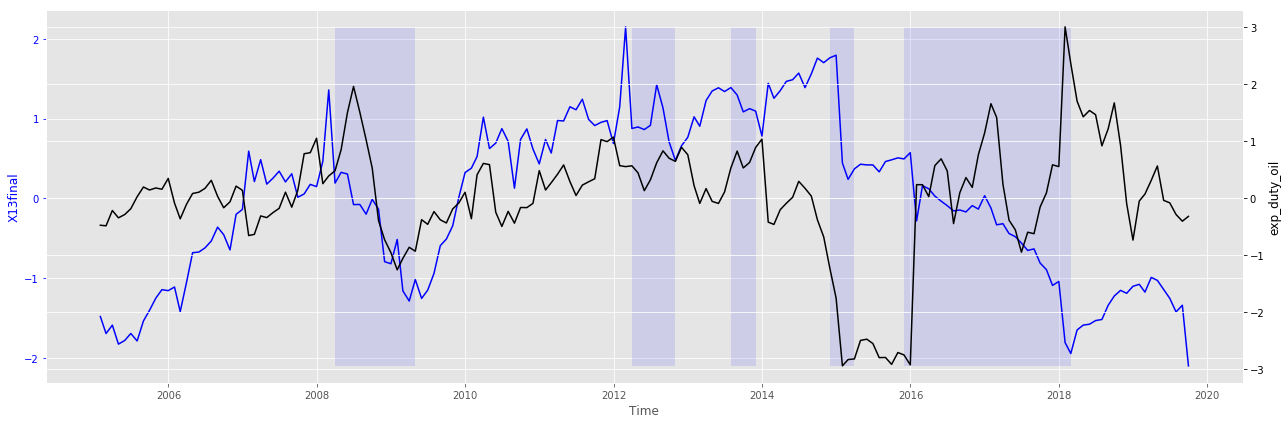

In [613]:
# 'exp_duty_oil', 'inv_CA', 's_ca', 'e_ca'
fplot(real_block.index, preproc(real_block.X13final),preproc(real_block.exp_duty_oil),real_block.CA_binar,1)

In [614]:
candidate_series=real_block.exp_duty_oil
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())

adf:  -2.366969569707707
p-value:  0.151276799022664
Critical values:  {'1%': -3.4680615871598537, '5%': -2.8781061899535128, '10%': -2.5756015922004134}
есть единичные корни, ряд не стационарен
adf:  -4.571475596235872
p-value:  0.00014574365795516983
Critical values:  {'1%': -3.471633386932248, '5%': -2.8796651107461972, '10%': -2.576433647235832}
единичных корней нет, ряд стационарен


In [615]:
dd=pd.concat([real_block.X13final.diff().dropna(),preproc(real_block.exp_duty_oil).diff().dropna()],axis=1)
grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True)
# Экспорт скорее совпадающий, потому как нефть добываюти сразу в трубу, а не хранят


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3826  , p=0.5370  , df_denom=172, df_num=1
ssr based chi2 test:   chi2=0.3893  , p=0.5327  , df=1
likelihood ratio test: chi2=0.3889  , p=0.5329  , df=1
parameter F test:         F=0.3826  , p=0.5370  , df_denom=172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4969  , p=0.6093  , df_denom=169, df_num=2
ssr based chi2 test:   chi2=1.0233  , p=0.5995  , df=2
likelihood ratio test: chi2=1.0203  , p=0.6004  , df=2
parameter F test:         F=0.4969  , p=0.6093  , df_denom=169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5983  , p=0.6170  , df_denom=166, df_num=3
ssr based chi2 test:   chi2=1.8707  , p=0.5997  , df=3
likelihood ratio test: chi2=1.8606  , p=0.6018  , df=3
parameter F test:         F=0.5983  , p=0.6170  , df_denom=166, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9094  , p=0.4599  

{1: ({'ssr_ftest': (0.38262774499286145, 0.5370185657183228, 172.0, 1),
   'ssr_chi2test': (0.389301484731109, 0.5326667996598666, 1),
   'lrtest': (0.38886910971598354, 0.532894445369241, 1),
   'params_ftest': (0.38262774499274216, 0.5370185657184042, 172.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.4969425216888021, 0.6092741356372667, 169.0, 2),
   'ssr_chi2test': (1.02328992631777, 0.5995085977043833, 2),
   'lrtest': (1.0202926996071824, 0.6004077028327224, 2),
   'params_ftest': (0.49694252168883246, 0.6092741356372495, 169.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5983302243501577, 0.6169576298855608, 166.0, 3),
   'ssr_chi2test': (1.8706830508297099, 0.5996755972078363, 3),
   'lrtest': (1.8606413426055042, 0.6018284315235558, 3),
   'params_ftest': (0.5983302243501646, 0.6169576298855526, 166.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

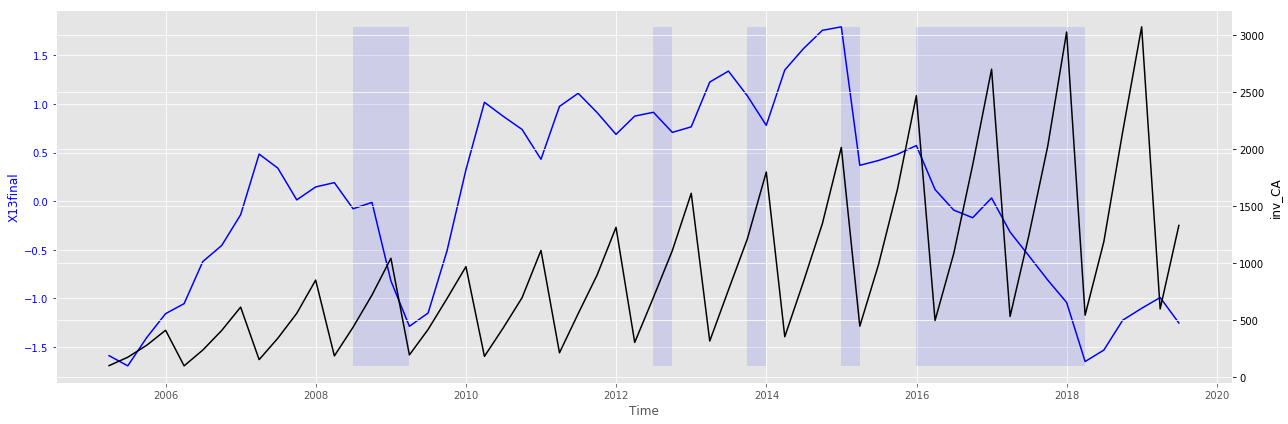

In [32]:
#  'inv_CA', 's_ca', 'e_ca'
aa=preproc(real_block.X13final).resample('Q').last()[:-1]#.diff().dropna()
bb=real_block.inv_CA.fillna(0).resample('Q').sum()[:-1]#.diff().dropna()
cc=real_block.CA_binar.resample('Q').mean()[:-1]
fplot(aa.index, aa,bb,cc,1)

In [33]:
candidate_series=bb
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())

adf:  0.6164237867300257
p-value:  0.988013528498721
Critical values:  {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}
есть единичные корни, ряд не стационарен
adf:  -3.942240213054732
p-value:  0.001745063269302879
Critical values:  {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}
единичных корней нет, ряд стационарен


In [34]:
dd=pd.concat([aa,bb],axis=1)
grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2745  , p=0.0759  , df_denom=54, df_num=1
ssr based chi2 test:   chi2=3.4564  , p=0.0630  , df=1
likelihood ratio test: chi2=3.3556  , p=0.0670  , df=1
parameter F test:         F=3.2745  , p=0.0759  , df_denom=54, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0614  , p=0.1378  , df_denom=51, df_num=2
ssr based chi2 test:   chi2=4.5270  , p=0.1040  , df=2
likelihood ratio test: chi2=4.3533  , p=0.1134  , df=2
parameter F test:         F=2.0614  , p=0.1378  , df_denom=51, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5728  , p=0.2082  , df_denom=48, df_num=3
ssr based chi2 test:   chi2=5.4063  , p=0.1443  , df=3
likelihood ratio test: chi2=5.1568  , p=0.1607  , df=3
parameter F test:         F=1.5728  , p=0.2082  , df_denom=48, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3686  , p=0.2599  , df_d

{1: ({'ssr_ftest': (3.2744594049291686, 0.07593316809671727, 54.0, 1),
   'ssr_chi2test': (3.456373816314122, 0.06300835336013065, 1),
   'lrtest': (3.3556323591928248, 0.0669754825879154, 1),
   'params_ftest': (3.274459405244795, 0.07593316808299527, 54.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.0613818667086137, 0.13775247109146813, 51.0, 2),
   'ssr_chi2test': (4.526956256301269, 0.10398817084855923, 2),
   'lrtest': (4.353279449431824, 0.11342202021877619, 2),
   'params_ftest': (2.0613818667136936, 0.1377524710908207, 51.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.572753386586935, 0.20816819968052364, 48.0, 3),
   'ssr_chi2test': (5.4063397663925885, 0.14434910003372609, 3),
   'lrtest': (5.1568482470895844, 0.1606656985130141, 3),
   'params_ftest': (1.5727533865860641, 0.2081681996807336, 48.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.,

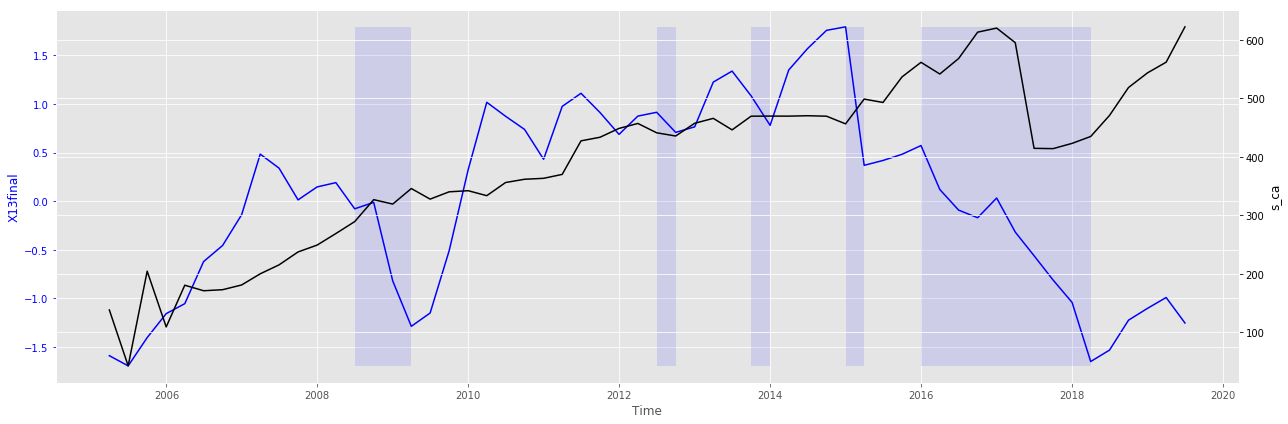

In [41]:
#  's_ca', 
aa=preproc(real_block.X13final).resample('Q').last()[:-1]#.diff().dropna()
bb=real_block.s_ca.fillna(0).resample('Q').sum()[:-1]#.diff().dropna()
cc=real_block.CA_binar.resample('Q').mean()[:-1]
fplot(aa.index, aa,bb,cc,1)

In [42]:
candidate_series=bb
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())

adf:  -1.3125145989355682
p-value:  0.6234275984997681
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
есть единичные корни, ряд не стационарен
adf:  -10.529582129233024
p-value:  9.225998107593474e-19
Critical values:  {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}
единичных корней нет, ряд стационарен


In [43]:
dd=pd.concat([aa.diff().dropna(),bb[1:]],axis=1)
grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1847  , p=0.1453  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=2.3084  , p=0.1287  , df=1
likelihood ratio test: chi2=2.2621  , p=0.1326  , df=1
parameter F test:         F=2.1847  , p=0.1453  , df_denom=53, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5749  , p=0.2171  , df_denom=50, df_num=2
ssr based chi2 test:   chi2=3.4648  , p=0.1769  , df=2
likelihood ratio test: chi2=3.3600  , p=0.1864  , df=2
parameter F test:         F=1.5749  , p=0.2171  , df_denom=50, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2658  , p=0.2970  , df_denom=47, df_num=3
ssr based chi2 test:   chi2=4.3628  , p=0.2249  , df=3
likelihood ratio test: chi2=4.1955  , p=0.2411  , df=3
parameter F test:         F=1.2658  , p=0.2970  , df_denom=47, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2944  , p=0.2869  , df_d

{1: ({'ssr_ftest': (2.18472543665193, 0.14530452785144365, 53.0, 1),
   'ssr_chi2test': (2.30838914061336, 0.12867734144968881, 1),
   'lrtest': (2.2620801467410274, 0.13257587592988845, 1),
   'params_ftest': (2.184725436651943, 0.14530452785144124, 53.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.5749023571978125, 0.21712422409998544, 50.0, 2),
   'ssr_chi2test': (3.4647851858351877, 0.1768607475741125, 2),
   'lrtest': (3.3600283814787133, 0.18637133127365876, 2),
   'params_ftest': (1.574902357197869, 0.21712422409997456, 50.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.2657566086468321, 0.29695244878488697, 47.0, 3),
   'ssr_chi2test': (4.362820651080571, 0.22485763505135342, 3),
   'lrtest': (4.195530423699708, 0.2411097556519393, 3),
   'params_ftest': (1.2657566086470735, 0.2969524487848062, 47.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0

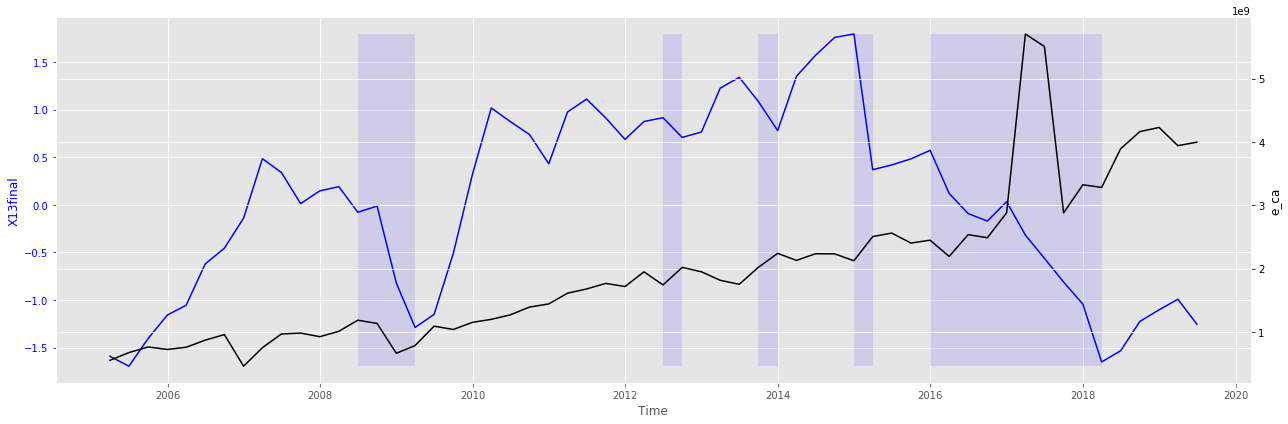

In [44]:
#  ''e_ca'
aa=preproc(real_block.X13final).resample('Q').last()[:-1]#.diff().dropna()
bb=real_block.e_ca.fillna(0).resample('Q').sum()[:-1]#.diff().dropna()
cc=real_block.CA_binar.resample('Q').mean()[:-1]
fplot(aa.index, aa,bb,cc,1)

In [45]:
candidate_series=bb
adfuller_series(candidate_series)
adfuller_series(candidate_series.diff().dropna())

adf:  0.13807684523287217
p-value:  0.9685666603270775
Critical values:  {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}
есть единичные корни, ряд не стационарен
adf:  -6.5687791922876295
p-value:  8.033560457883525e-09
Critical values:  {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}
единичных корней нет, ряд стационарен


In [46]:
dd=pd.concat([aa.diff().dropna(),bb.diff().dropna()],axis=1)
grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0401  , p=0.8421  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=0.0423  , p=0.8370  , df=1
likelihood ratio test: chi2=0.0423  , p=0.8370  , df=1
parameter F test:         F=0.0401  , p=0.8421  , df_denom=53, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5648  , p=0.5720  , df_denom=50, df_num=2
ssr based chi2 test:   chi2=1.2427  , p=0.5372  , df=2
likelihood ratio test: chi2=1.2288  , p=0.5410  , df=2
parameter F test:         F=0.5648  , p=0.5720  , df_denom=50, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5859  , p=0.6272  , df_denom=47, df_num=3
ssr based chi2 test:   chi2=2.0195  , p=0.5684  , df=3
likelihood ratio test: chi2=1.9826  , p=0.5760  , df=3
parameter F test:         F=0.5859  , p=0.6272  , df_denom=47, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9612  , p=0.4383  , df_d

{1: ({'ssr_ftest': (0.04007278690465124, 0.8421044816068913, 53.0, 1),
   'ssr_chi2test': (0.042341057861518296, 0.8369710223812714, 1),
   'lrtest': (0.04232505909340034, 0.8370013937442066, 1),
   'params_ftest': (0.04007278690466572, 0.8421044816068683, 53.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5648485335251495, 0.5720310692713533, 50.0, 2),
   'ssr_chi2test': (1.2426667737553287, 0.5372276275394366, 2),
   'lrtest': (1.228836338772851, 0.5409555482616415, 2),
   'params_ftest': (0.5648482465434975, 0.5720312298066734, 50.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5858984292934633, 0.6272478445446352, 47.0, 3),
   'ssr_chi2test': (2.01947969245832, 0.5683734817591957, 3),
   'lrtest': (1.9826335081200739, 0.5760189981256341, 3),
   'params_ftest': (0.5858982581513462, 0.6272479547139735, 47.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 

financ_block
'nomex', 'brent', 'ipp_nonprod', 'ipp_prod', 'credit', 'payment',
       'deposit_peop', 'm2_seas_adj'

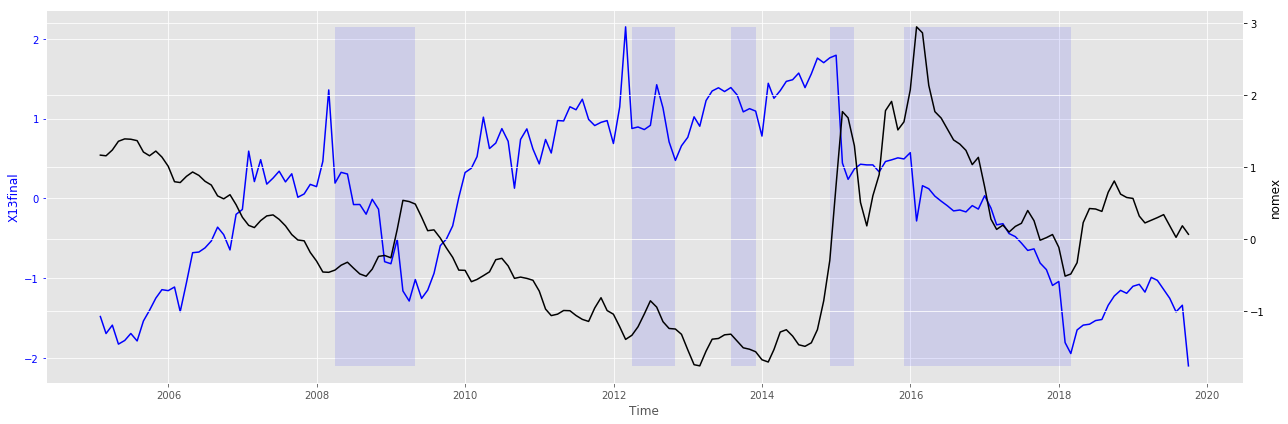

In [47]:
fplot(real_block.index, preproc(real_block.X13final),preproc(financ_block.nomex),real_block.CA_binar,1)

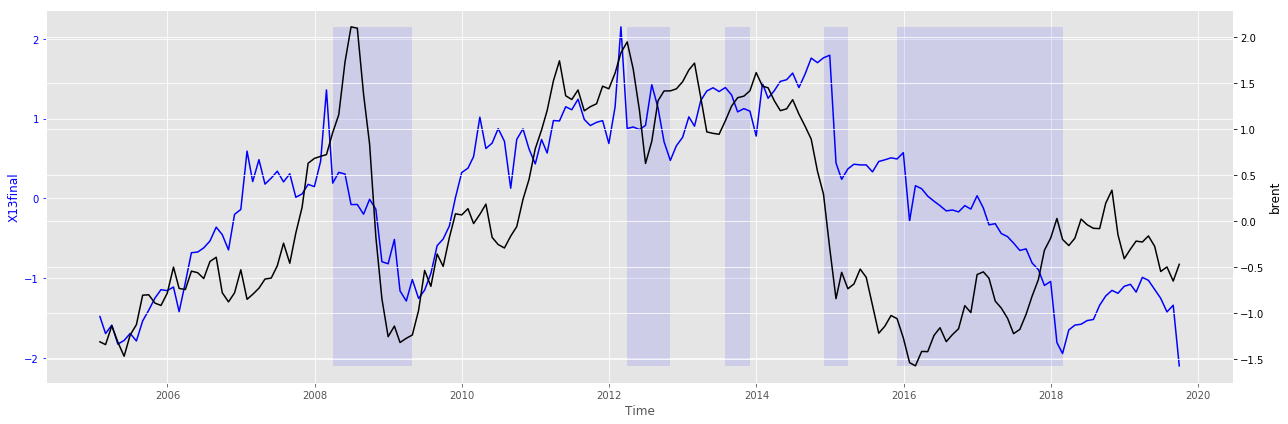

In [626]:
fplot(real_block.index, preproc(real_block.X13final),preproc(financ_block.brent),real_block.CA_binar,1)

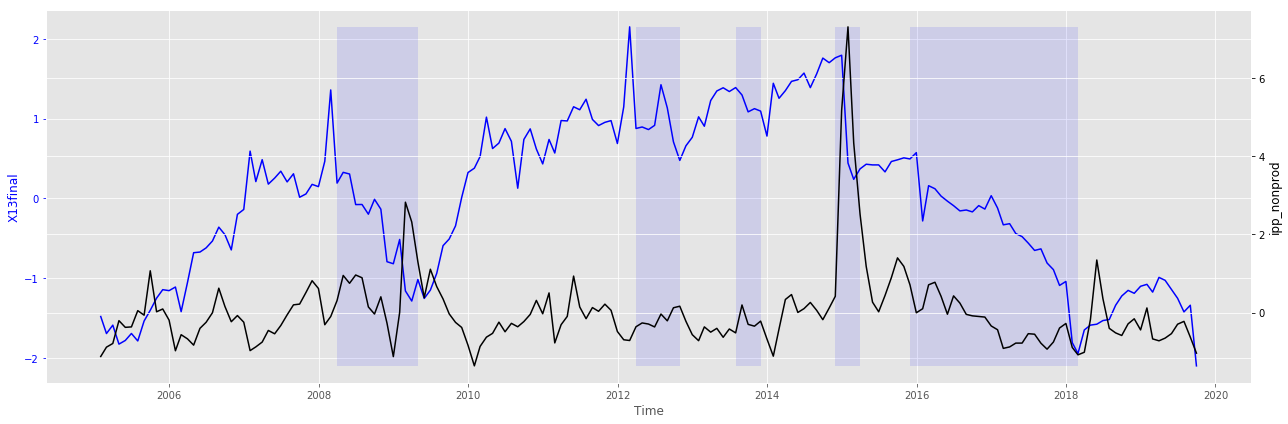

In [627]:
fplot(real_block.index, preproc(real_block.X13final),preproc(financ_block.ipp_nonprod),real_block.CA_binar,1)

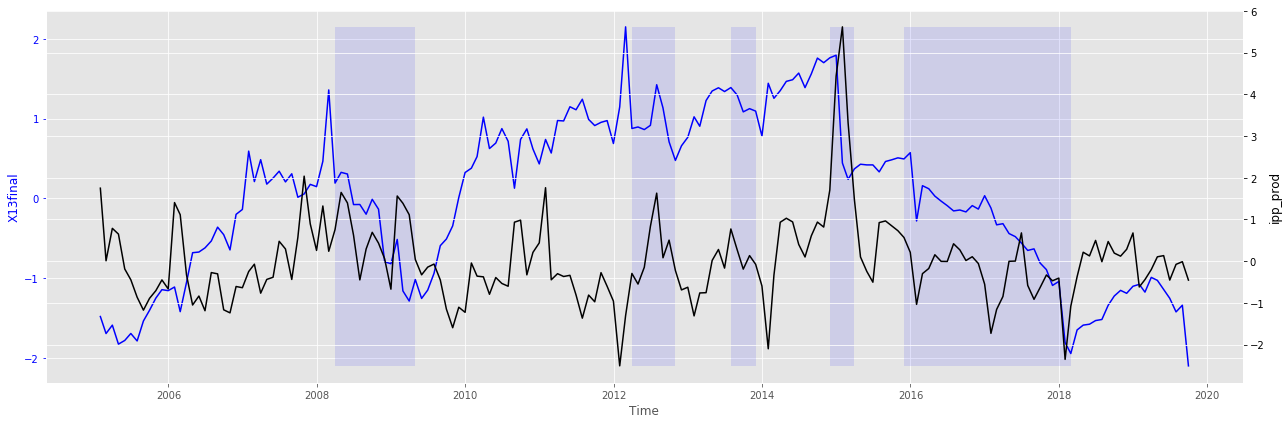

In [628]:
fplot(real_block.index, preproc(real_block.X13final),preproc(financ_block.ipp_prod),real_block.CA_binar,1)

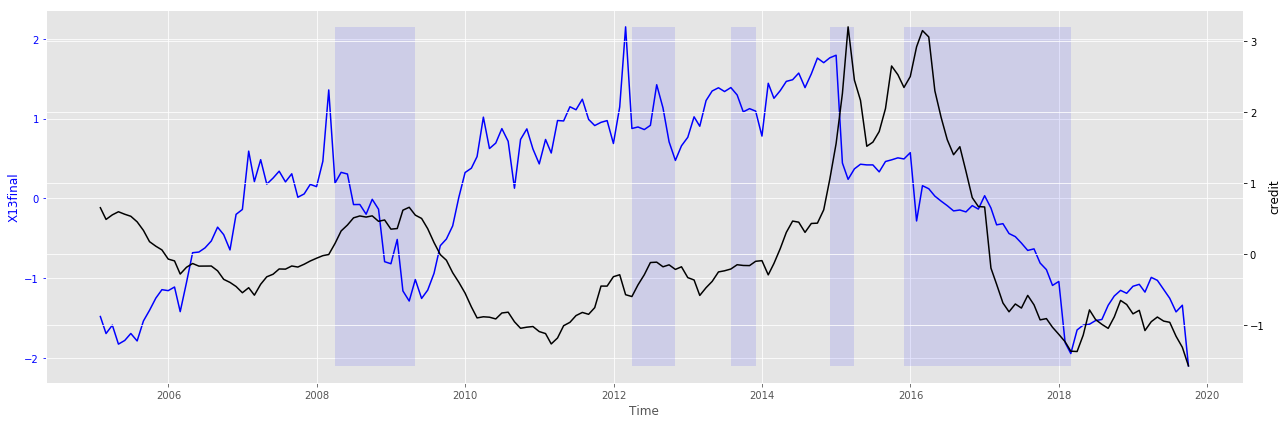

In [629]:
fplot(real_block.index, preproc(real_block.X13final),preproc(financ_block.credit),real_block.CA_binar,1)

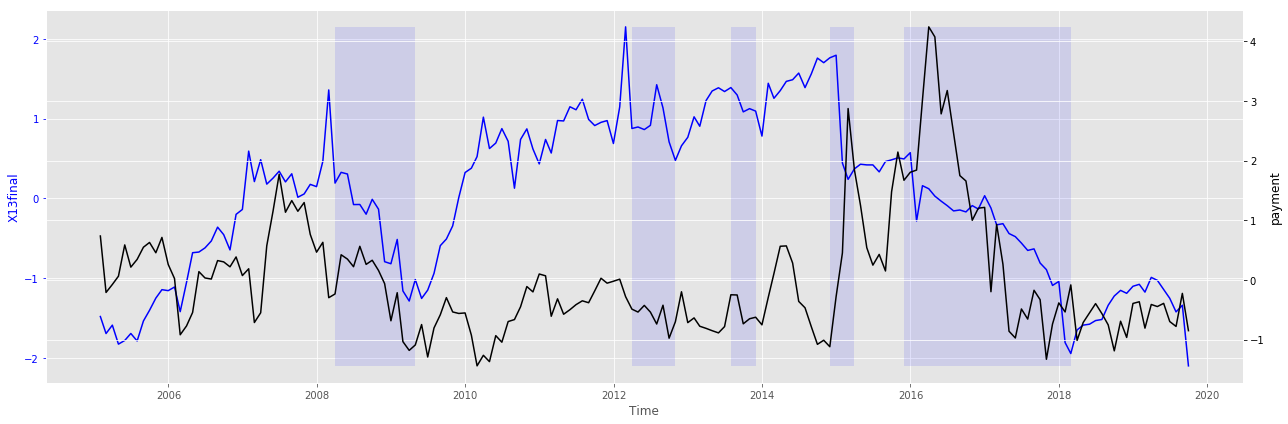

In [630]:
# payment
fplot(real_block.index, preproc(real_block.X13final),preproc(financ_block.payment),real_block.CA_binar,1)

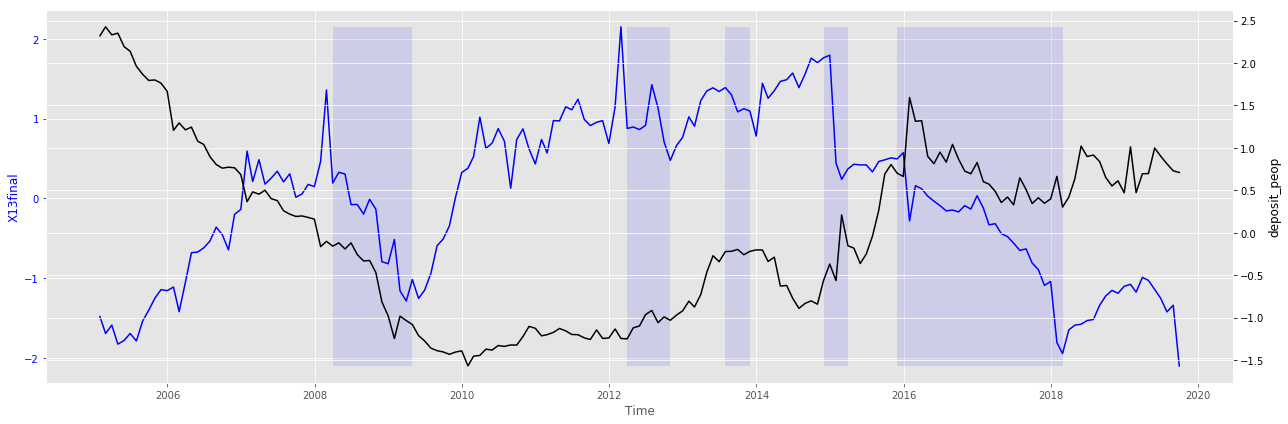

In [631]:
fplot(real_block.index, preproc(real_block.X13final),preproc(financ_block.deposit_peop),real_block.CA_binar,1)

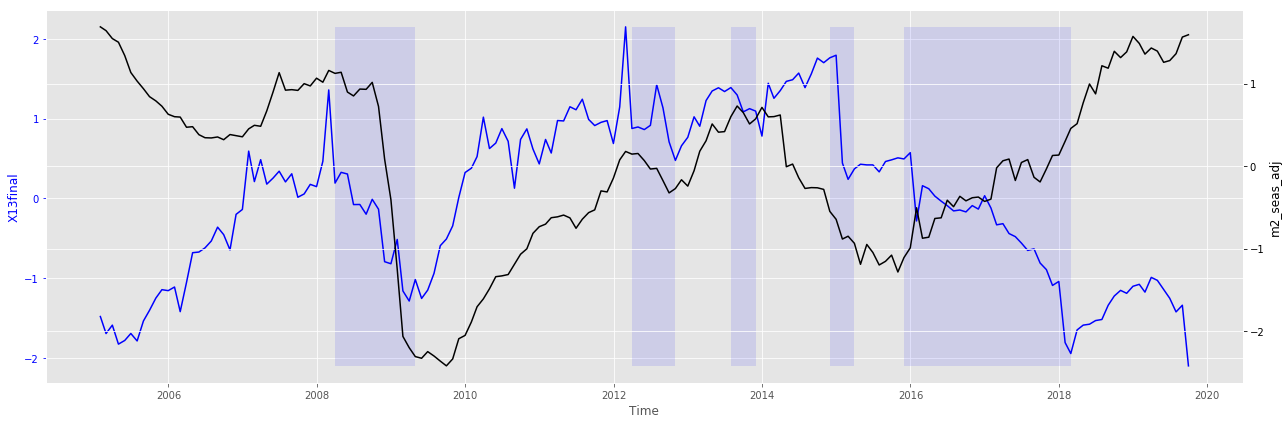

In [632]:
fplot(real_block.index, preproc(real_block.X13final),preproc(financ_block.m2_seas_adj),real_block.CA_binar,1)

In [712]:
real_block.columns

Index(['X13final', 'CA_binar', 'inconf_r', 'inconf_e', 'ps_ca', 'ps_ew',
       'ndpi', 'exp_duty_oil', 'inv_CA', 's_ca', 'e_ca'],
      dtype='object')

In [716]:
adfuller(X['inv_CA'].dropna())

(0.6164237867300257,
 0.988013528498721,
 4,
 53,
 {'1%': -3.560242358792829,
  '5%': -2.9178502070837,
  '10%': -2.5967964150943397},
 540.8968443924246)

In [12]:
X=real_block
dict_t={'Name':[],'adf: ':[],'p-value: ':[],'Critical values 10%: ':[],'unit root':[]}
for i in  X.columns:
    print(i)
    test = adfuller(preproc(X[i].dropna()))
    if test[0]> test[4]['5%']:
        test = adfuller(X[i].dropna().diff().dropna())
        dict_t['Name'].append(i)
        dict_t['adf: '].append(round(test[0],3))
        dict_t['p-value: '].append(round(test[1],3))
        dict_t['Critical values 10%: '].append(round(test[4]['10%'],3))
        dict_t['unit root'].append('единичных корней нет, ряд стационарен в разностях')
    else:
        dict_t['Name'].append(i)
        dict_t['adf: '].append(round(test[0],3))
        dict_t['p-value: '].append(round(test[1],3))
        dict_t['Critical values 10%: '].append(round(test[4]['10%'],3))
        dict_t['unit root'].append('единичных корней нет, ряд стационарен')

X13final
CA_binar
inconf_r
inconf_e
ps_ca
ps_ew
ndpi
exp_duty_oil
inv_CA
s_ca
e_ca


In [10]:
pd.DataFrame(dict_t)#.to_excel('adf_real.xlsx')

,Name,adf:,p-value:,Critical values 10%:,unit root
0,X13final,-11.512,0.000,-2.576,"единичных корней нет, ряд стационарен в разностях"
1,CA_binar,-3.409,0.011,-2.576,"единичных корней нет, ряд стационарен"
2,inconf_r,-3.397,0.011,-2.576,"единичных корней нет, ряд стационарен в разностях"
3,inconf_e,-7.281,0.000,-2.576,"единичных корней нет, ряд стационарен"
4,ps_ca,-2.910,0.044,-2.576,"единичных корней нет, ряд стационарен"
5,ps_ew,-8.262,0.000,-2.576,"единичных корней нет, ряд стационарен в разностях"
6,ndpi,-11.666,0.000,-2.576,"единичных корней нет, ряд стационарен в разностях"
7,exp_duty_oil,-3.626,0.005,-2.576,"единичных корней нет, ряд стационарен"
8,inv_CA,-3.942,0.002,-2.597,"единичных корней нет, ряд стационарен в разностях"
9,s_ca,-10.530,0.000,-2.595,"единичных корней нет, ряд стационарен в разностях"


In [11]:
for i in  financ_block.columns:
    print('_'*100)
    print(i)
    candidate_series=financ_block[i]
    adfuller_series(candidate_series)
#     adfuller_series(candidate_series.diff().dropna())

____________________________________________________________________________________________________
nomex
adf:  -0.39215557830226055
p-value:  0.9114002990796526
Critical values:  {'1%': -3.469413468959902, '5%': -2.8786964197028295, '10%': -2.5759166089965397}
есть единичные корни, ряд не стационарен
____________________________________________________________________________________________________
brent
adf:  -2.754100744798491
p-value:  0.0651351411862057
Critical values:  {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}
есть единичные корни, ряд не стационарен
____________________________________________________________________________________________________
ipp_nonprod
adf:  -5.113185199986644
p-value:  1.318794444840278e-05
Critical values:  {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}
единичных корней нет, ряд стационарен
______________________________________________________________________________________

In [635]:
for i in  financ_block.columns:
    print('__________________________')
    print(i)
    candidate_series=financ_block[i]
    dd=pd.concat([real_block.X13final.diff().dropna(),preproc(candidate_series).diff().dropna()],axis=1)
    grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True).values

__________________________
nomex

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0394  , p=0.0261  , df_denom=172, df_num=1
ssr based chi2 test:   chi2=5.1273  , p=0.0236  , df=1
likelihood ratio test: chi2=5.0536  , p=0.0246  , df=1
parameter F test:         F=5.0394  , p=0.0261  , df_denom=172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0942  , p=0.0479  , df_denom=169, df_num=2
ssr based chi2 test:   chi2=6.3716  , p=0.0413  , df=2
likelihood ratio test: chi2=6.2577  , p=0.0438  , df=2
parameter F test:         F=3.0942  , p=0.0479  , df_denom=169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2647  , p=0.0829  , df_denom=166, df_num=3
ssr based chi2 test:   chi2=7.0806  , p=0.0694  , df=3
likelihood ratio test: chi2=6.9395  , p=0.0739  , df=3
parameter F test:         F=2.2647  , p=0.0829  , df_denom=166, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F tes

ssr based F test:         F=2.1932  , p=0.0908  , df_denom=166, df_num=3
ssr based chi2 test:   chi2=6.8571  , p=0.0766  , df=3
likelihood ratio test: chi2=6.7246  , p=0.0812  , df=3
parameter F test:         F=2.1932  , p=0.0908  , df_denom=166, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7541  , p=0.1406  , df_denom=163, df_num=4
ssr based chi2 test:   chi2=7.4037  , p=0.1160  , df=4
likelihood ratio test: chi2=7.2488  , p=0.1233  , df=4
parameter F test:         F=1.7541  , p=0.1406  , df_denom=163, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9109  , p=0.0953  , df_denom=160, df_num=5
ssr based chi2 test:   chi2=10.2114 , p=0.0695  , df=5
likelihood ratio test: chi2=9.9181  , p=0.0776  , df=5
parameter F test:         F=1.9109  , p=0.0953  , df_denom=160, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6489  , p=0.1372  , df_denom=157, df_num=6
ssr based chi2 test: 

ssr based F test:         F=0.1229  , p=0.9741  , df_denom=163, df_num=4
ssr based chi2 test:   chi2=0.5186  , p=0.9717  , df=4
likelihood ratio test: chi2=0.5178  , p=0.9717  , df=4
parameter F test:         F=0.1229  , p=0.9741  , df_denom=163, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.2946  , p=0.9154  , df_denom=160, df_num=5
ssr based chi2 test:   chi2=1.5744  , p=0.9043  , df=5
likelihood ratio test: chi2=1.5671  , p=0.9052  , df=5
parameter F test:         F=0.2946  , p=0.9154  , df_denom=160, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.4163  , p=0.8674  , df_denom=157, df_num=6
ssr based chi2 test:   chi2=2.7047  , p=0.8449  , df=6
likelihood ratio test: chi2=2.6834  , p=0.8474  , df=6
parameter F test:         F=0.4163  , p=0.8674  , df_denom=157, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4090  , p=0.8957  , df_denom=154, df_num=7
ssr based chi2 test: 

In [13]:
all_d=pd.concat([real_block,financ_block],axis=1)
all_d.describe()#.to_excel('all_d_describe.xlsx')

,X13final,CA_binar,inconf_r,inconf_e,ps_ca,ps_ew,ndpi,exp_duty_oil,inv_CA,s_ca,e_ca,nomex,brent,ipp_nonprod,ipp_prod,credit,payment,deposit_peop,m2_seas_adj
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,58.000000,58.000000,5.800000e+01,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,109.770603,0.322034,0.412429,-2.088475,94.637062,74.370169,5378.264191,5498.033336,930.479310,391.343276,1.977753e+09,40.481406,77.169121,100.520621,100.654011,18812.402216,5981.283767,13505.481615,23835.709982
std,3.500113,0.949414,4.919958,6.868786,27.893186,23.632293,3348.370652,3181.555245,745.019378,139.874534,1.200693e+09,16.082494,24.727294,0.366261,0.586018,10292.278559,3115.462305,8652.364832,12805.500340
min,101.051539,-1.000000,-16.000000,-20.000000,40.010000,29.780000,1660.100430,728.953571,97.100000,42.380000,4.606743e+08,23.347896,32.302083,100.080000,99.460000,2823.617812,1058.224692,1779.562696,4133.034607
25%,107.524010,-1.000000,-2.330000,-7.670000,72.900000,54.920000,2868.006743,2451.557899,408.050000,321.100000,1.018312e+09,28.228133,57.626452,100.320000,100.340000,11127.766054,3310.459759,5561.126531,12558.948614
50%,110.734020,1.000000,1.000000,-2.000000,88.810000,68.790000,4607.115546,5781.250204,696.100000,430.500000,1.760108e+09,31.398767,71.587826,100.430000,100.540000,18125.612289,5783.753216,12259.547856,23831.088983
75%,112.145120,1.000000,4.000000,3.000000,123.210000,99.660000,5801.073978,7471.491911,1231.500000,470.250000,2.478272e+09,58.006632,103.163077,100.640000,100.820000,29785.804094,9269.247573,22327.569946,33842.371033
max,115.794544,1.000000,10.000000,10.000000,173.430000,132.830000,15393.473884,15170.373120,3071.000000,622.500000,5.703152e+09,77.934425,134.509615,103.200000,103.850000,33829.440230,11052.799887,29058.128085,47865.630905


In [13]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_real_block=pca.fit_transform(preproc(real_block.drop(['X13final','inv_CA','s_ca','e_ca','CA_binar'],axis=1)))
pca_financ_block=pca.fit_transform(preproc(financ_block))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


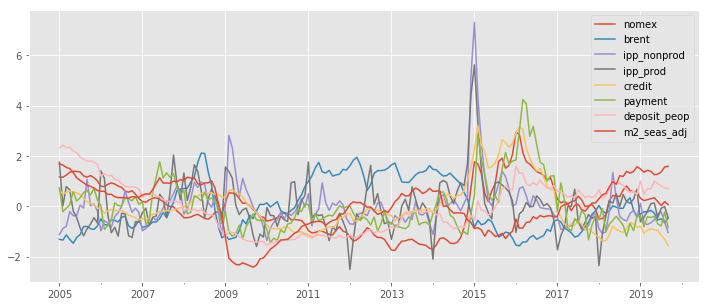

In [14]:
# fig=preproc(real_block.drop(['X13final','inv_CA','s_ca','e_ca','CA_binar'],axis=1)).plot(figsize=(12,5)).get_figure()
fig2=preproc(financ_block).plot(figsize=(12,5)).get_figure()

In [17]:
# fig3.savefig('pca.png')

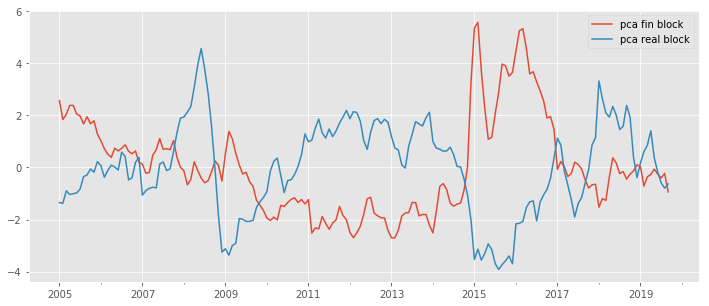

In [16]:
f_pca=pd.Series(pca_financ_block.flatten(),index=financ_block.index,name='pca fin block')
r_pca=pd.Series(pca_real_block.flatten(),index=financ_block.index,name='pca real block')
fig3=pd.concat([f_pca,r_pca],axis=1).plot(figsize=(12,5)).get_figure()
# plt.plot(pca_financ_block)
# fplot(real_block.index, preproc(real_block.X13final),pd.Series(pca_financ_block.flatten()),real_block.CA_binar,1)
# fplot(real_block.index, preproc(real_block.X13final),pd.Series(pca_real_block.flatten()),real_block.CA_binar,1)
# real_pd=pd.Series(pca_real_block.flatten(),index=real_block.index)
# finac_pd=pd.Series(pca_financ_block.flatten(),index=financ_block.index)

# candidate_series=finac_pd
# dd=pd.concat([real_block.X13final,candidate_series],axis=1)
# grangercausalitytests(dd, maxlag=12, addconst=True, verbose=True).values

In [18]:
a=real_block['CA_binar'].values#отбрасываем последнее значение, т.к. нам им нечем предсказывать, предполагая, что лаг -1
ipp_=np.where(a==-1, 0, a)[1:]#t значение бинарной соответсвует t-1 значение индекса

two_pca=np.stack([pca_real_block,pca_financ_block],axis=1).reshape(177,2)[1:]#t значение pca соответствует t-1 значение ipp в уровнях
ipp_val=preproc(real_block.X13final).values.reshape(177,1)[:-1]#делаем лаг для ipp в уровнях
exog=np.hstack([ipp_val,two_pca])

In [19]:
import statsmodels.api as sm
logit_model=sm.Logit(ipp_,sm.add_constant(exog))
result=logit_model.fit_regularized(method='l1',alpha=0.001)
# result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5748965833735523
            Iterations: 50
            Function evaluations: 50
            Gradient evaluations: 50
QC check did not pass for 1 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.104     
Dependent Variable: y                AIC:              210.3594  
Date:               2020-01-21 17:45 BIC:              223.0413  
No. Observations:   176              Log-Likelihood:   -101.18   
Df Model:           3                LL-Null:          -112.93   
Df Residuals:       172              LLR p-value:      3.1814e-05
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     50.0000       

### Поч не использовать для сетки такую интерпретацию??...отрезаем последний слой перед лог рег, вытаскиваем в явном виде ряды, прогноняем лог рег и смотрим на значимость коэффициентов.

In [77]:
data_sep=119
dates=real_block.index[1:]
print('точка разделения данных: {}'.format(dates[data_sep]))

def create_Xt_Yt(X_itog,Y_itog, data_sep=data_sep):
   
    X_train = np.array(pd.DataFrame(X_itog).loc[:data_sep])
    Y_train = np.array(pd.Series(Y_itog).loc[:data_sep])
     

 
    X_test = np.array(pd.DataFrame(X_itog).loc[data_sep:])
    Y_test = np.array(pd.Series(Y_itog).loc[data_sep:])

    return X_train, X_test, Y_train, Y_test

from collections import Counter
X_train, X_test, y_train, y_test = create_Xt_Yt(exog, ipp_)

len(X_train), len(X_test), len(y_train), len(y_test)

print('На обучающей выборке:\n периодов роста: {} \n периодов рецессии: {}'.format(Counter(y_train)[1],Counter(y_train)[0]))
print('На тестовой выборке:\n периодов роста: {} \n периодов рецессии: {}'.format(Counter(y_test)[1],Counter(y_test)[0]))

точка разделения данных: 2015-01-31 00:00:00
На обучающей выборке:
 периодов роста: 90 
 периодов рецессии: 30
На тестовой выборке:
 периодов роста: 26 
 периодов рецессии: 31


In [78]:
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(120,)
(57,)
(120, 3)
(57, 3)


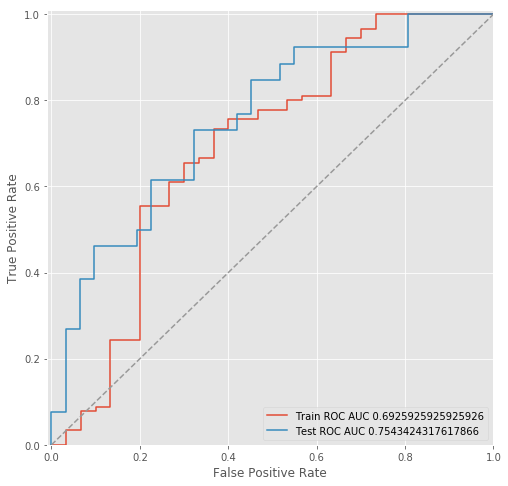

На тестовой выборке:
 периодов роста: 26 
 периодов рецессии: 31

 H0- рецессия, а H1- рост!!!!
 FP - ошибка первого рода (говорим, что рост, но на самом деле рецессия) 
 FN - ошибка второго рода (говорим, что рецессия, но на самом деле рост)

Counter({0.0: 20, 1.0: 19, 2.0: 11, -1.0: 7})
TP:19 FP:11 
FN:7 TN:20

precision(TN/TN+FN) for 0 =0.74
recall(TN/TN+FP) for 0 =0.65

precision(TP/TP+FP) for 1 =0.63
recall(TP/TP+FN) for 1 =0.73

log_loss_test= 0.596
accuracy_score_test= 0.684
roc_auc_score_test= 0.754


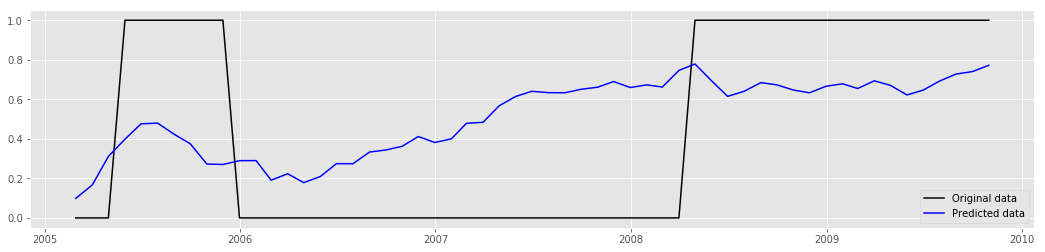

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, roc_curve
import matplotlib



parameters = {'C':np.logspace(-2,2,50)}
clf0 = LogisticRegression(penalty='l2', class_weight='balanced')
clf2 = GridSearchCV(clf0, parameters, cv=5, scoring='roc_auc')
clf2.fit(X_train,y_train)
clf=clf2.best_estimator_

# # y_pred = clf.fit(X_train, y_train).predict(X_test)# не нужно, потом что я его считаю сам через вероятности с порогом 0,5 в 
probs_y=clf.predict_proba(X_test) 
roc_auc_pic(clf, y_train, y_test, X_train, X_test)
pr=print_rez(0.6,dates[:-data_sep],y_test,probs_y,for_NN=False)#первый аргумент - даты пандаса для подписей графика, 
# #второй - тестовая выборка, последний аргумент - это ряд вероятностей

head=['Дата {}'.format(ctm()),'Используемые переменные: 2 pca and lag of ipp','точка разделения данных: {}'.format(dates[data_sep])]
      
intellegens('\n'.join(head+pr))#записываем логи
      
      

### ANN

In [27]:
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

import keras.backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
def size(model): # Compute number of params in a model (the actual number of floats)
    return sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
from sklearn.metrics import roc_auc_score


#для расчета roc-auc внутри нейронки
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping

from keras.utils import plot_model
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

Using TensorFlow backend.


<Figure size 576x576 with 0 Axes>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3)                 12        
_________________________________________________________________
dropout_3 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 4         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1)                 0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1)                 4         
__________

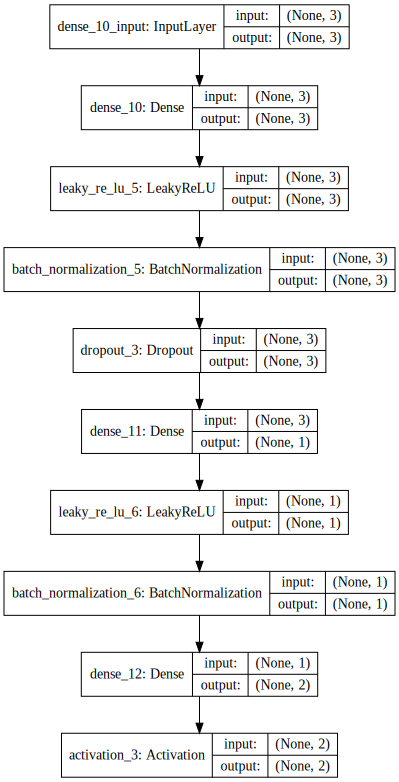

In [93]:
from keras import backend as K

K.set_learning_phase(0) #set learning phase
# It is stated here that: The "learning phase" is a flag is a flag which indicates training/inference. 
#     It is set to 1 when using e.g. fit and to 0 when using e.g. predict. K.set_learning_phase(False) 
#     sets the "learning phase" to be always 0, i.e. fit will have the model behave in inference mode
#     (e.g. no dropout and BatchNorm behavior set to inference)

model = Sequential()

model.add(Dense(3, input_dim=X_train.shape[1],
                activity_regularizer=regularizers.l2(0.01)))
model.add(LeakyReLU())
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(1,
                activity_regularizer=regularizers.l2(0.01)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.summary()
# функци рисующая схему неросети

from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='network00.png')
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))




In [97]:
opt = Nadam(lr=0.001)

#Reduce learning rate when a metric has stopped improving.  можно добавить в колбеки в fit
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
#сохраняет лучшие веса после каждой эпохи, нужно добавить в колбеки в fit
# checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy',auc_roc])

#если не перестает улучшаться на протяжении patience эпох останавливаем обучение
# my_callbacks = [EarlyStopping(monitor='auc_roc', patience=300, verbose=1, mode='max')]
checkpoint = ModelCheckpoint("weights.hdf5", monitor='auc_roc', mode='max', save_best_only=True, verbose=0)

Y_train=transf_Y(y_train)
Y_test=transf_Y(y_test)
history = model.fit(X_train, Y_train, 
          nb_epoch = 170, 
          batch_size = X_train.shape[0], #мы используем метод стохастического градиентного спуска, размер мини-выбрки составляет 128 элементов
          #тое сть мы анализируем 128 итераций (паттернов), определяем направление градиента и в соответствии с этим направлениевм выполняем изменение весов.
          verbose=0, 
          validation_data=(X_test, Y_test),
          shuffle=False,
          callbacks=[checkpoint])

Отношение числа наблюдений к кол-ву оцениваемых параметров:12.86

last val_loss = 2.939
last accuracy = 0.456
last val_auc_roc = 0.574

На тестовой выборке:
 периодов роста: 26 
 периодов рецессии: 31

 H0- рецессия, а H1- рост!!!!
 FP - ошибка первого рода (говорим, что рост, но на самом деле рецессия) 
 FN - ошибка второго рода (говорим, что рецессия, но на самом деле рост)

Counter({0.0: 31, -1.0: 26})
TP:0 FP:0 
FN:26 TN:31

precision(TN/TN+FN) for 0 =0.54
recall(TN/TN+FP) for 0 =1.0

precision(TP/TP+FP) for 1 =0.0
recall(TP/TP+FN) for 1 =0.0

log_loss_test= 0.76
accuracy_score_test= 0.544
roc_auc_score_test= 0.484


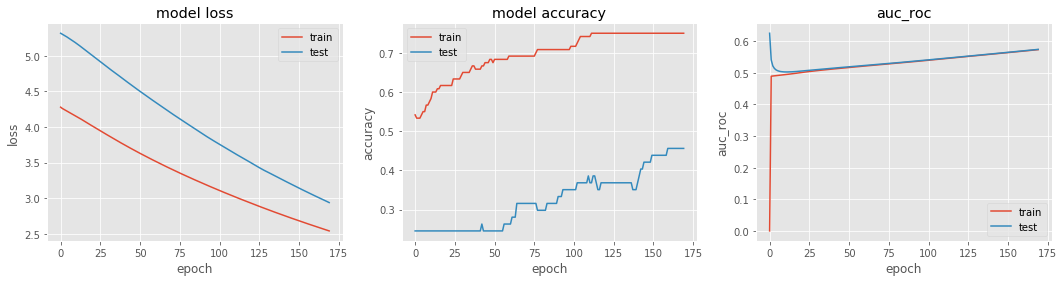

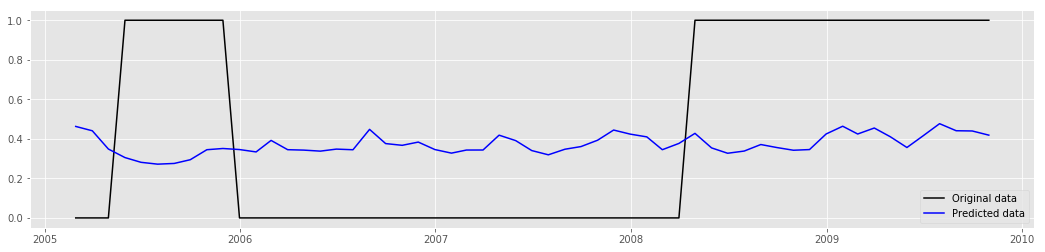

In [98]:
from_nn=print_3plots(history)
prob_y_ann=model.predict(X_test)
body=print_rez(0.5,dates[:-data_sep],y_test,model.predict(X_test),for_NN=True)
# первый аргумент - даты пандаса для подписей графика, 
# второй - тестовая выборка, последний аргумент - это ряд вероятностей

head=['Дата {}'.format(ctm()),'Используемые переменные: 2 pca, lagged ipp','точка разделения данных: {}'.format(dates[data_sep])]
intellegens('\n'.join(head+body+from_nn))#записываем логи
import json
intellegens(json.dumps(model.get_config()))#записывать в файл с логами еще и структура нейронки

In [181]:
# def compute_loss(y_hat, y):
#     return  y*np.log(y_hat)+(1-y)*np.log(1-y_hat)
# a=compute_loss(model.predict(X_test)[:,0], y_test)
# plt.hist(a,10)

In [90]:
#смотреть по годам, что происходило
# for i in range(0,14):
#     plt.plot(ex[12*i:12*i+12])
#     plt.show() 
#     plt.close() 

### CNN 

### convolution neural network

In [36]:
from numpy import hstack
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

from keras.utils import plot_model
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


In [37]:
real_pd=pd.Series(pca_real_block.flatten(),index=real_block.index)
finac_pd=pd.Series(pca_financ_block.flatten(),index=financ_block.index)
ipp_pd=preproc(real_block['X13final'])
quart_data=preproc(real_block[['inv_CA', 's_ca', 'e_ca']].dropna(),freq_n=4)
# добавляем последний квартал с NA, чтоб размерности совпадали
quart_data=pd.concat([quart_data,real_block[['inv_CA', 's_ca', 'e_ca']].tail(1)],axis=0)
ipp_bin=real_block['CA_binar']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


In [38]:
two_pca=pd.concat([real_pd,finac_pd,ipp_pd,ipp_bin],axis=1)
two_pca.columns=['real','finac','ipp','ipp_bin']

In [39]:
itog_x, itog_quart, itog_y=month_train_sample(two_pca,quart_data,n=12)
itog_x=[i.drop(0,axis=1) for i in itog_x]
itog_y=[i['ipp_bin'] for i in itog_y]

In [40]:
p_m3=np.array([i.fillna(method='pad').values for i in itog_x])
p_gdp=np.array([i.values for i in itog_quart])
# Берем только первый три квартала. Для n_steps=15 это будут  t-2, t-3, t-4 кварталы. 
# Значения для t и t-1 будут взяты из сверток. 
p_gdp_cut=np.array([p_gdp[i][:3,:] for i in range(0,len(p_gdp))])
y_m3_1d=np.array(itog_y).reshape(len(itog_x))
y_m3=transf_Y(y_m3_1d)

In [41]:
print(p_m3.shape,p_gdp_cut.shape,np.array(y_m3).shape)

(165, 15, 4) (165, 3, 3) (165, 2)


In [58]:
n=120-12
X_cnn_train=p_m3[:n]
X_cnn_test=p_m3[n:]

quart_train=p_gdp_cut[:n]
quart_test=p_gdp_cut[n:]

y_cnn_train=y_m3[:n]
Y_cnn_test=y_m3[n:]

n_steps=15

In [59]:
print(len(y_cnn_train))
len(Y_cnn_test)

108


57

In [60]:
n_features = X_cnn_train.shape[2]

inp_m = Input(shape=(n_steps, n_features),name='monthly')

# cnn = Conv1D(filters=10, kernel_size=2, 
#               activation='linear')(inp_m)

# for i in range(9):
#     cnn = Conv1D(filters=10, kernel_size=2, 
# #               strides=3,
#               activation='linear')(cnn)


month_inp = Conv1D(filters=1, 
             kernel_size=3,
             strides=3,
             activation='tanh')(inp_m)
month_inp=Conv1D(filters=1,kernel_size=1,activation='linear')(month_inp)

#берем 
def slice(x):
    return x[:,:2]
last_two_quart = Lambda(slice)(month_inp)


quart_inp = Input(shape=(3, 3),name='quartality')
quart_inp_1d=Conv1D(filters=1,kernel_size=1,activation='linear')(quart_inp)

# Добавляем к квартальным данным на места квараталов t и t-1 соответствующие представления месячных данных
quart_con=concatenate([quart_inp_1d,last_two_quart],axis=1)

# а еще мы можем так же восстанавливать месячные данные, которых нет, ставя туда значение свертки


z = concatenate([month_inp,quart_con],axis=-1)
# merge = Conv1D(filters=1, kernel_size=1, activation='linear')(z)
merge=Conv1D(filters=1,kernel_size=3,activation='linear')(z)

merge = Flatten()(merge)
# output = Dense(1, activation='linear')(merge)
output = Dense(2, activation='sigmoid')(merge)

model = Model(inputs=[inp_m,quart_inp], outputs=output)
model.summary()

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='network111.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
monthly (InputLayer)            (None, 15, 4)        0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 5, 1)         13          monthly[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 5, 1)         2           conv1d_9[0][0]                   
__________________________________________________________________________________________________
quartality (InputLayer)         (None, 3, 3)         0                                            
__________________________________________________________________________________________________
conv1d_11 

In [61]:
# opt = Nadam(lr=0.01)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy',auc_roc])

checkpoint = ModelCheckpoint("weights.hdf5", monitor='auc_roc', mode='max', save_best_only=True, verbose=0)

history = model.fit([X_cnn_train,quart_train], y_cnn_train, 
          epochs = 300, 
          batch_size = 100, 
          verbose=0, 
          validation_data=([X_cnn_test,quart_test], Y_cnn_test),
          shuffle=False,
        callbacks=[checkpoint])


Отношение числа наблюдений к кол-ву оцениваемых параметров:10.59

last val_loss = 0.636
last accuracy = 0.561
last val_auc_roc = 0.859

На тестовой выборке:
 периодов роста: 26 
 периодов рецессии: 31

 H0- рецессия, а H1- рост!!!!
 FP - ошибка первого рода (говорим, что рост, но на самом деле рецессия) 
 FN - ошибка второго рода (говорим, что рецессия, но на самом деле рост)

Counter({-1: 24, 0: 24, 2: 7, 1: 2})
TP:2 FP:7 
FN:24 TN:24

precision(TN/TN+FN) for 0 =0.5
recall(TN/TN+FP) for 0 =0.77

precision(TP/TP+FP) for 1 =0.22
recall(TP/TP+FN) for 1 =0.08

log_loss_test= 0.636
accuracy_score_test= 0.456
roc_auc_score_test= 0.87


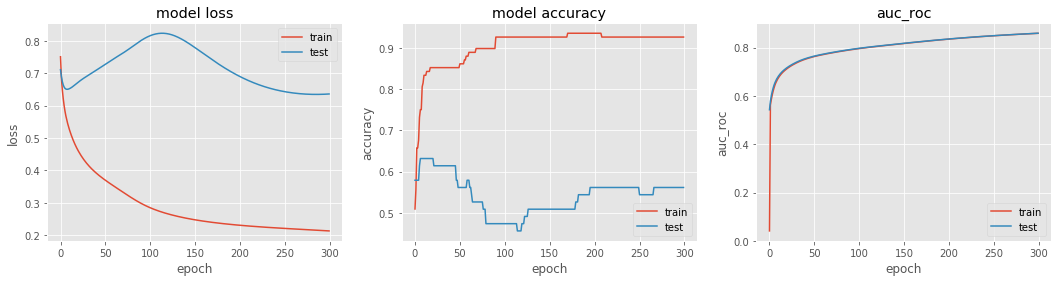

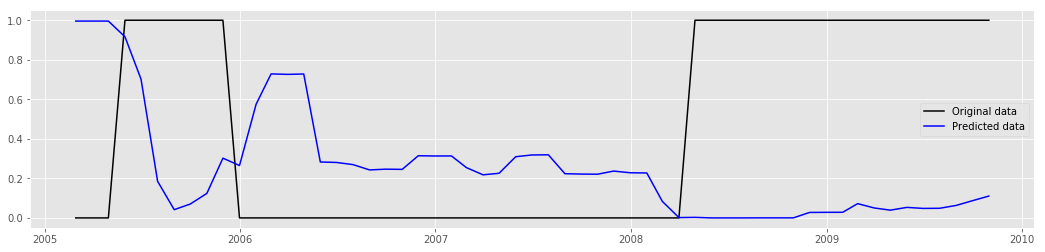

In [62]:
from_cnn=print_3plots(history)
# prob_y_cnn=model.predict([X_cnn_test,quart_test])
body=print_rez(0.5,dates[:len(Y_cnn_test)],np.array(Y_cnn_test)[:,0],model.predict([X_cnn_test,quart_test]),for_NN=True)

head=['Дата {}'.format(ctm()),'Используемые переменные: 2 pca, lagged ipp','точка разделения данных: {}'.format(dates[data_sep])]
intellegens('\n'.join(head+body+from_nn))#записываем логи
intellegens(json.dumps(model.get_config()))#записывать в файл с логами еще и структура нейронки
#отношение числа наблюдей ни парм это только с учетом месячных данных

### Рисуем все 

In [63]:
len(y_test)
len(dates[:-data_sep])
m_d=pd.date_range(start='2015-01-31',periods=57,freq='M')

In [102]:
def plot_test_all(dates,y_test,y_probs1,y_probs2,y_probs3):
    plt.subplots(figsize=(18,4))
    plt.plot(dates,y_test, color='black', label = 'Original')#проверить правильно ли дата разбивается
    plt.plot(dates,y_probs1, color='blue', label = 'Predicted LR')
    plt.plot(dates,y_probs2, color='green', label = 'Predicted ANN')
    plt.plot(dates,y_probs3, color='orange', label = 'Predicted CNN')
     
    plt.plot(dates,[0.5]*len(dates), color='red')
    plt.legend(loc='best')
#     plt.show()
    plt.savefig('test01090.png')

In [103]:
os.getcwd()

'/Users/vladimirkosarev/Desktop/Yandex.Disk.localized/2_disser_aspa/data/Сбор_Росстат'

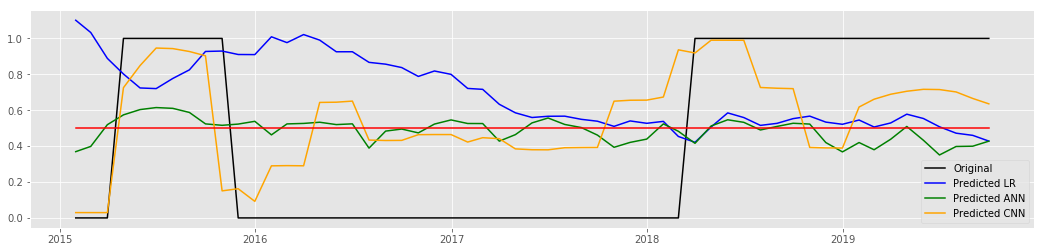

In [104]:
plot_test_all(m_d,y_test,
              probs_y[:,0]+0.2,
              prob_y_ann[:,0]-0.15,
              prob_y_cnn[:,0])

### Доверительные интервалы для предсказания

In [43]:
from keras.models import Model, Sequential
from keras import backend as K

def create_dropout_predict_function(model, dropout):
    """
    Create a keras function to predict with dropout
    model : keras model
    dropout : fraction dropout to apply to all layers
    
    Returns
    predict_with_dropout : keras function for predicting with dropout
    """
    # Load the config of the original model
    conf = model.get_config()
    # Add the specified dropout to all layers
    for layer in conf['layers']:
        # ищем слой дропаута и заменяем в нем значение вероятности
        if layer["class_name"]=="Dropout":
            layer["config"]["rate"] = dropout
        # Recurrent layers with dropout
        elif "dropout" in layer["config"].keys():
            layer["config"]["dropout"] = dropout

    # создаем новую модель с измененными параметрами дропаута
    if type(model)==Sequential:
        # Sequential
        model_dropout = Sequential.from_config(conf)
    else:
        # Functional
        model_dropout = Model.from_config(conf)
    model_dropout.set_weights(model.get_weights()) 
    
    # Create a function to predict with the dropout on
    predict_with_dropout = K.function(model_dropout.inputs+[K.learning_phase()], model_dropout.outputs)
    
    return predict_with_dropout


In [91]:
import numpy as np
from keras.models import load_model

dropout = 0.5
num_iter = 20
num_samples = X_cnn_test1.shape[0]

# path_to_model = "../models/pretrainedmodel.hdf5"
# model = load_model(path_to_model)

predict_with_dropout = create_dropout_predict_function(model, dropout)

input_data=[X_cnn_test1,X_cnn_test2,invest_test]

predictions = np.zeros((num_samples, num_iter))
for i in range(num_iter):
    predictions[:,i] = predict_with_dropout(input_data+[1])[0][:,0].reshape(-1)

In [93]:
ci = 0.8
lower_lim = np.quantile(predictions, 0.5-ci/2, axis=1)
upper_lim = np.quantile(predictions, 0.5+ci/2, axis=1)

In [120]:
fn=lambda x : 1 if x>0.5 else 0
y_pred=[fn(i) for i in predictions[:,0]]

In [121]:
#  -(yt log(yp) + (1 - yt) log(1 - yp))

log_loss(Y_cnn_test_re[:,0],y_pred)

18.65100322104618

In [80]:
# roc_auc_pic(model, y_cnn_train_re, Y_cnn_test_re, X_train, X_test)
# model.predict_proba([X_cnn_train1,X_cnn_train2,invest_train])
model.predict([X_cnn_train1,X_cnn_train2,invest_train])
model.predict([X_cnn_test1,X_cnn_test2,invest_test])

array([[0.49804476, 0.5024761 ],
       [0.49804476, 0.5024761 ],
       [0.49804476, 0.5024761 ],
       ...,
       [0.49804476, 0.5024761 ],
       [0.4976868 , 0.5023724 ],
       [0.49804476, 0.5024761 ]], dtype=float32)

### старая сетка без соответствия месячных представлений кварталам

In [7]:
from numpy import hstack
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

from keras.utils import plot_model
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#для расчета roc-auc внутри нейронки
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping


# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

Using TensorFlow backend.


In [8]:
np.random.seed(42)#для воспроизводимости результатов
X_cnn_train1=np.random.random_sample((50000,12, 1))
X_cnn_train2=np.random.random_sample((50000,12, 3))

X_cnn_test1=np.random.random_sample((1000,12, 1))
X_cnn_test2=np.random.random_sample((1000,12, 3))

invest_train=np.random.random_sample((50000,4,3))
invest_test=np.random.random_sample((1000,4,3))

def y_sample(size):
    a=np.random.randint(2,size=size)
    return np.stack([a,1-a]).transpose()

y_cnn_train_re=y_sample(50000)
Y_cnn_test_re=y_sample(1000)

n_steps=12

path='/Users/vladimirkosarev/Desktop/Yandex.Disk.localized/2_disser_aspa/Python/'
Image(filename= path+"2019-11-15 12-47-26.JPG",width=500, height=100) 

#1-d свертка всегда сворачивает всю панель фаткоров в одно наблюдение.
n_features1 = X_cnn_train1.shape[2]
n_features2 = X_cnn_train2.shape[2]

visible1 = Input(shape=(n_steps, n_features1),name='Index_val')
cnn1 = Conv1D(filters=1, kernel_size=3,
#               padding='causal',
#               dilation_rate=4,#это внцтри ядра между пикселями будет по 3 пикселя пропущено
              strides=3,
              activation='relu',activity_regularizer=regularizers.l2(0.01))(visible1)

# second input model
visible2 = Input(shape=(n_steps, n_features2),name='PCA_result')
cnn2 = Conv1D(filters=1, kernel_size=3, 
#               padding='causal',
#               dilation_rate=4,
              strides=3,
              activation='relu',activity_regularizer=regularizers.l2(0.01))(visible2)
#чтоб не смешивать ряды между собой заранее нужно отдельный инпут тогда для каждого 

inv_inp = Input(shape=(4, 3),name='invest')
#сюда можно одновременно все квартальные показатели впихнуть, просто размерность будет (4,n)
# z = Add() ([cnn2,inv_inp])# а можно и так или нет?
z = concatenate([cnn2,inv_inp],axis=-1)
out = Conv1D(filters=1, kernel_size=1,activation='relu',activity_regularizer=regularizers.l2(0.01))(z)

# merge input models
merge = concatenate([cnn1, out],axis=-1)
merge = Conv1D(filters=1, kernel_size=1, activation='relu',activity_regularizer=regularizers.l2(0.01))(merge)
merge = Flatten()(merge)
output = Dense(2, activation='sigmoid')(merge)
model = Model(inputs=[visible1, visible2,inv_inp], outputs=output)
model.summary()


SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
# from keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file='network2.png')

np.random.seed(42)#для воспроизводимости результатов
X_cnn_train1=np.random.random_sample((5000,12, 1))
X_cnn_train2=np.random.random_sample((5000,12, 3))

X_cnn_test1=np.random.random_sample((100,12, 1))
X_cnn_test2=np.random.random_sample((100,12, 3))

invest_train=np.random.random_sample((5000,4,3))
invest_test=np.random.random_sample((100,4,3))

def y_sample(size):
    a=np.random.randint(2,size=size)
    return np.stack([a,1-a]).transpose()

y_cnn_train_re=y_sample(5000)
Y_cnn_test_re=y_sample(100)

n_steps=12

#1-d свертка всегда сворачивает в всю панель фаткоров в одно наблюдение.
n_features1 = X_cnn_train1.shape[2]
n_features2 = X_cnn_train2.shape[2]

visible1 = Input(shape=(n_steps, n_features1),name='Index_val')

cnn1 = Conv1D(filters=1, kernel_size=3,
              strides=3,
              activation='relu')(visible1)


# second input model
visible2 = Input(shape=(n_steps, n_features2),name='PCA_result')
cnn2 = Conv1D(filters=1, kernel_size=2, 
              activation='relu')(visible2)
cnn2 = Dropout(0.5)(cnn2)

cnn2 = Conv1D(filters=1, kernel_size=2,
              strides=3,
              activation='relu')(cnn2)



inv_inp = Input(shape=(4, 3),name='invest')
#сюда можно одновременно все квартальные показатели впихнуть, просто размерность будет (4,n)

z = concatenate([cnn2,inv_inp],axis=-1)

out = Conv1D(filters=1, kernel_size=1,activation='relu',activity_regularizer=regularizers.l2(0.01))(z)

# merge input models
merge = concatenate([cnn1, out],axis=-1)
merge = Dropout(0.5)(merge)
merge = Conv1D(filters=1, kernel_size=1, activation='relu',activity_regularizer=regularizers.l2(0.01))(merge)
merge = Flatten()(merge)
merge = Dropout(0.5)(merge)
output = Dense(2, activation='sigmoid')(merge)
model = Model(inputs=[visible1, visible2,inv_inp], outputs=output)
model.summary()


SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
# from keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file='network2.png')

opt = Nadam(lr=0.001)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy',auc_roc])
checkpoint = ModelCheckpoint("weights.hdf5", monitor='auc_roc', mode='max', save_best_only=True, verbose=0)

history = model.fit([X_cnn_train1,X_cnn_train2,invest_train], y_cnn_train_re, 
          nb_epoch = 10, 
          batch_size = 10000, 
          verbose=1, 
          validation_data=([X_cnn_test1,X_cnn_test2,invest_test], Y_cnn_test_re),
          shuffle=False,
          callbacks=[checkpoint])

print_3plots(history)